<a href="https://colab.research.google.com/github/Hubert26/suicides_IPPAN/blob/main/suicides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Liblaries and settings

In [1144]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

#Ustawienie braku maksymalnej ilości wyświetlanych kolumn
pd.options.display.max_columns = None

np.random.seed(42)

#Function definitions

## display_info

In [905]:
def display_info(df, selected_columns):
    print(selected_columns)
    print(len(selected_columns))
    for col_name in selected_columns:

        # Mode
        print("\nMode:")
        print(df[col_name].mode())

        # NaN count
        nan_count = df[col_name].isna().sum()
        print("\nNaN count:", nan_count)

        # Unique values len
        print("\nUnique values len:")
        print(len(df[col_name].unique()))

        # Unique values
        print("\nUnique values:")
        print(df[col_name].unique())

        # Value counts
        print("\nValue counts:")
        print(df[col_name].value_counts())

        print("\n" + "=" * 40)  # Separator between columns


## create_bar_plot

In [906]:
def create_bar_plot(x_values, y_values, x_label, y_label, title, x_rotation=0):

    # Tworzenie wykresu słupkowego
    plt.bar(x_values, y_values)

    # Dodanie wartości nad słupkami
    for i in range(len(x_values)):
        plt.text(x_values[i], y_values[i], str(y_values[i]), ha='center', va='bottom')

    # Dodanie tytułu i etykiet osi
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Wyświetlenie wykresu
    plt.xticks(rotation=x_rotation, ha='right')
    plt.tight_layout()
    plt.show()


##create_double_bar_plot

In [907]:
def create_double_bar_plot(x_values, y_values1, y_values2, x_label, y_label, title, x_rotation=0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # Tworzenie dwóch subplotów obok siebie

    # Utworzenie słupków dla obu serii danych
    bars1 = ax1.bar(x_values, y_values1, label='Series 1')
    bars2 = ax2.bar(x_values, y_values2, label='Series 2')

    # Dodanie wartości nad słupkami dla serii 1
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Dodanie wartości nad słupkami dla serii 2
    for bar in bars2:
        height = bar.get_height()
        ax2.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Dodanie tytułów i etykiet osi
    ax1.set_title(title)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')

    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')

    # Wyświetlenie wykresu
    plt.tight_layout()
    plt.show()

##plot_confusion_matrix

In [1135]:
def plot_confusion_matrix(cm, model):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(
        width=500,
        height=500,
        title=model+' Confusion Matrix',
        font_size=16,
        template='plotly_dark'
        )
    fig.show()

##plot_roc_curve

**pogrubiony tekst**
 Receiver Operating Characteristic
1. True Positive Rate (TPR) = FP / (FP+TN)
2. False Positive Rate (FPR) = TP / (TP+FN)

In [1142]:
def plot_roc_curve(y_test, y_pred, model):
    # Binary classification
    from sklearn.metrics import roc_curve
    fpr, tpr, tresh = roc_curve(y_test, y_pred, pos_label=1)

    fig = go.Figure(
        data=[
            go.Scatter(x=fpr, y=tpr,
                    line_color='red',
                    name='ROC Curve'),
            go.Scatter(x=[0, 1], y=[0, 1],
                    mode='lines',
                    line_dash='dash',
                    line_color='#F012BE')
        ],
        layout=go.Layout(xaxis_title='False Positive Rate',
                         yaxis_title='True Positive Rate',
                         title = model + ' ROC Curve',
                         showlegend=False,
                         template='plotly_dark',
                         width=700))
    fig.show()


##model_validation


Precision (precyzja) = TP / (TP+FP): Ile obserwacji przewidzianych jako pozytywne jest w rzeczywistości pozytywne.

Recall (czułość) = TP / (TP+FN): Ile obserwacji z wszystkich pozywtywnych sklasyfikowaliśmy jako pozytywne.

F1-score: ważona średnia harmonicza między precyzją a czułością;

Support (wsparcie): liczba próbek, które należą do każdej z klas;

Accuracy (dokładność) = (TP+TN) /(TP+TN+FP+FN))

FPR (False Positive Rate) = FP / (FP+TN) [type I error]

FNR (False Negative Rate) = FN / (FN+TP) [type II error]

In [910]:
def model_validation(y_test, y_pred, model):
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average="weighted")
  recall = recall_score(y_test, y_pred, average="weighted")
  f1 = f1_score(y_test, y_pred, average="weighted")
  roc_score = roc_auc_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)
  tn, fp, fn, tp = cm.ravel()
  fpr = fp / (fp + tn) # False Positive Rate - Type I error
  fnr = fn / (fn + tp) # False Negative Rate - Type II error

  model_results = pd.DataFrame([{'accuracy': accuracy,
                                 'precision': precision,
                                 'recall': recall,
                                 'f1': f1,
                                 'AUROC': roc_score,
                                 'fpr': fpr,
                                 'fnr': fnr
                                 }],
                                  index=[str(model)]
                               )
  return model_results

##plot_learning_curve

In [911]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :param train_sizes:
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#Data exploration

In [912]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/suicides_IPPAN/main/data/df_data.csv', delimiter=',', low_memory=False)

In [913]:
df_raw.head()

,suicide_id,report_date_year,report_date_month,age_group,gender,marital_status,education,work_study_info,livelihood_source,is_fatal,location_of_attack,method_of_committing,consciousness_state,substance_info,treatment_info,"reasons_of_attack_Bullying, cyberbullying, harassment",reasons_of_attack_Chronic illness,reasons_of_attack_Committing a crime or misdemeanor,reasons_of_attack_Conflict with non-family members,reasons_of_attack_Death of a close person,reasons_of_attack_Deterioration or sudden loss of health,reasons_of_attack_Family misunderstanding/family violence,"reasons_of_attack_HIV carrier, AIDS patient",reasons_of_attack_Love affair,reasons_of_attack_Mental illness/mental disorders,reasons_of_attack_Other unspecified,reasons_of_attack_Permanent disability,reasons_of_attack_Physical illness,reasons_of_attack_Poor economic conditions/debt,reasons_of_attack_School or work problems,reasons_of_attack_Sudden loss of livelihood,reasons_of_attack_Threat or loss of housing,reasons_of_attack_Unwanted pregnancy,reason_of_attack_count
0,114 581 552,2013,1,NaN,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,114 584 284,2013,1,13-18,male,NaN,NaN,Student,NaN,1.0,Road/street/sidewalk,Throwing oneself under a moving vehicle,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,114 584 293,2013,1,13-18,female,Single,Primary education,Student,Dependent on another person,1.0,Other,Jumping from a height,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,114 584 312,2013,1,19-24,male,Single,NaN,NaN,NaN,1.0,NaN,Other,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,114 584 399,2013,1,40-44,male,Single,NaN,Unemployed,NaN,1.0,Outbuildings,Hanging,Under the influence of alcohol,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [914]:
selected_columns = [
    'reasons_of_attack_Bullying, cyberbullying, harassment',
    'reasons_of_attack_Chronic illness',
    'reasons_of_attack_Committing a crime or misdemeanor',
    'reasons_of_attack_Conflict with non-family members',
    'reasons_of_attack_Death of a close person',
    'reasons_of_attack_Deterioration or sudden loss of health',
    'reasons_of_attack_Family misunderstanding/family violence',
    'reasons_of_attack_HIV carrier, AIDS patient',
    'reasons_of_attack_Love affair',
    'reasons_of_attack_Mental illness/mental disorders',
    'reasons_of_attack_Other unspecified',
    'reasons_of_attack_Permanent disability',
    'reasons_of_attack_Physical illness',
    'reasons_of_attack_Poor economic conditions/debt',
    'reasons_of_attack_School or work problems',
    'reasons_of_attack_Sudden loss of livelihood',
    'reasons_of_attack_Threat or loss of housing',
    'reasons_of_attack_Unwanted pregnancy'
]

df_data = df_raw.drop(columns=selected_columns)
df_data_reasons_of_attack = df_raw[selected_columns]

In [915]:
df_data['reason_of_attack_count'] = df_data['reason_of_attack_count'].replace(0, np.nan)

##NaN exploration in variables

In [916]:
df_data.shape

(113196, 16)

In [917]:
df_data[df_data['suicide_id'].duplicated()].suicide_id #Sprawdzenie duplikatów

Series([], Name: suicide_id, dtype: object)

In [918]:
##Brakujące dane
total = df_data.isnull().sum().sort_values(ascending=False)
percent = 100*(df_data.isnull().sum()/df_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [919]:
missing_data

,Total,Percent
treatment_info,108281,95.657974
substance_info,93753,82.823598
education,77929,68.844305
consciousness_state,58827,51.969151
work_study_info,55930,49.409873
livelihood_source,49338,43.586346
reason_of_attack_count,40058,35.388176
marital_status,14345,12.672709
age_group,1288,1.137849
location_of_attack,106,0.093643


##NaN exploration in rows

In [920]:
nan_counts = df_data.isna().sum(axis=1).value_counts()

In [921]:
full_index = list(range(0, len(df_data.columns.tolist()) + 1))

# Zsumowanie istniejących wartości z pełną listą i ustawienie brakujących wartości na 0
nan_counts = nan_counts.reindex(full_index, fill_value=0)

# Sortowanie wyników rosnąco
nan_counts = nan_counts.sort_index()

In [922]:
nan_counts_proc = (nan_counts / len(df_data)) * 100

In [923]:
missing_data_rows = pd.concat([nan_counts, nan_counts_proc], axis=1, keys=['Total', 'Percent'])
missing_data_rows

,Total,Percent
0,83,0.073324
1,3873,3.421499
2,15283,13.501360
3,19126,16.896357
4,19919,17.596912
5,21450,18.949433
6,17743,15.674582
7,11497,10.156719
8,3882,3.429450
9,263,0.232340


In [924]:
# Usunięcie wierszy z df_data i df_data_reasons_of_attack gdzie są NaN w 'gender' i 'age_group'
selected_index = df_data[df_data['gender'].isna() | df_data['age_group'].isna()].index

df_data = df_data.drop(index=selected_index)
df_data_reasons_of_attack = df_data_reasons_of_attack.drop(index=selected_index)

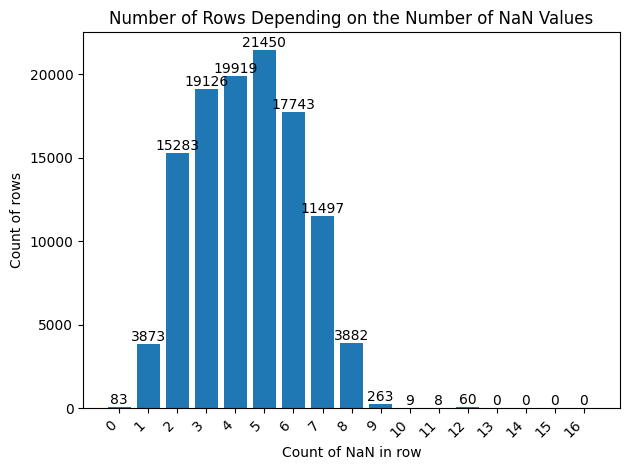

In [925]:
create_bar_plot(
                nan_counts.reset_index().iloc[:, 0].astype(str).tolist(),
                nan_counts.reset_index().iloc[:, 1].tolist(),
                'Count of NaN in row',
                'Count of rows',
                'Number of Rows Depending on the Number of NaN Values',
                x_rotation=45)

In [926]:
df_data['report_date_year'] = df_data['report_date_year'].astype(str)
df_data['report_date_month'] = df_data['report_date_month'].astype(str)


##data_age_groups

In [927]:
sorted(list(set(df_data['age_group'])))


['13-18',
 '19-24',
 '25-29',
 '30-34',
 '35-39',
 '40-44',
 '45-49',
 '50-54',
 '55-59',
 '60-64',
 '65-69',
 '7-12',
 '70-74',
 '75-79',
 '80-84',
 '85+']

###data_age_group_7-12

In [928]:
age_group = '7-12'

In [929]:
selected_index = df_data.loc[df_data['age_group'] == age_group].index

In [930]:
data_age_group = df_data.loc[selected_index]
data_age_group_reasons_of_attack = df_data_reasons_of_attack.loc[selected_index]

In [931]:
data_age_group.shape

(343, 16)

In [932]:
female_index = data_age_group.loc[data_age_group['gender'] == 'female'].index

In [933]:
male_index = data_age_group.loc[data_age_group['gender'] == 'male'].index

####NaN exploration in variables

In [934]:
##Brakujące dane
total = data_age_group.isnull().sum().sort_values(ascending=False)
percent = 100*(data_age_group.isnull().sum()/data_age_group.isnull().count()).sort_values(ascending=False)
missing_data_age_group = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [935]:
missing_data_age_group

,Total,Percent
substance_info,343,100.000000
treatment_info,343,100.000000
consciousness_state,120,34.985423
reason_of_attack_count,85,24.781341
education,44,12.827988
livelihood_source,17,4.956268
work_study_info,12,3.498542
marital_status,6,1.749271
suicide_id,0,0.000000
report_date_year,0,0.000000


####NaN exploration in rows

In [936]:
nan_counts = data_age_group.isna().sum(axis=1).value_counts()

In [937]:
full_index = list(range(0, len(data_age_group.columns.tolist()) + 1))

# Zsumowanie istniejących wartości z pełną listą i ustawienie brakujących wartości na 0
nan_counts = nan_counts.reindex(full_index, fill_value=0)

# Sortowanie wyników rosnąco
nan_counts = nan_counts.sort_index()

In [938]:
nan_counts_proc = (nan_counts / len(data_age_group)) * 100

In [939]:
missing_data_rows = pd.concat([nan_counts, nan_counts_proc], axis=1, keys=['Total', 'Percent'])
missing_data_rows

,Total,Percent
0,0,0.000000
1,0,0.000000
2,158,46.064140
3,116,33.819242
4,46,13.411079
5,17,4.956268
6,5,1.457726
7,1,0.291545
8,0,0.000000
9,0,0.000000


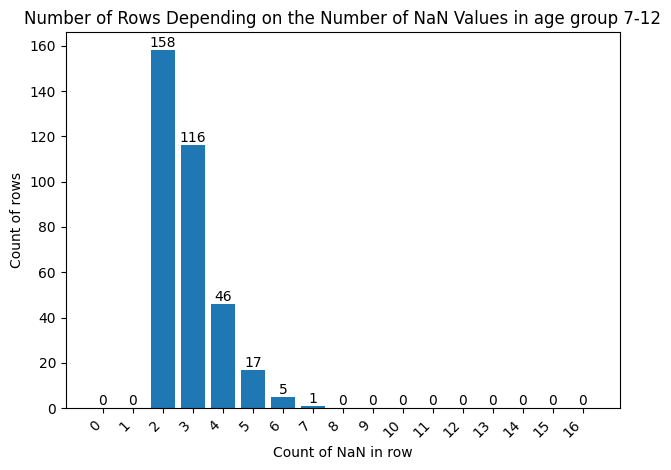

In [940]:
create_bar_plot(
                nan_counts.reset_index().iloc[:, 0].astype(str).tolist(),
                nan_counts.reset_index().iloc[:, 1].tolist(),
                'Count of NaN in row',
                'Count of rows',
                'Number of Rows Depending on the Number of NaN Values' + ' in age group ' + age_group,
                x_rotation=45)

In [941]:
# data_age_group = data_age_group[data_age_group_7_12.isna().sum(axis=1) <= 8]

####Variable - consciousness_state

In [942]:
variable = 'consciousness_state'

In [943]:
display_info(data_age_group, [variable])

['consciousness_state']
1

Mode:
0    Sober
Name: consciousness_state, dtype: object

NaN count: 120

Unique values len:
8

Unique values:
['Under the influence of alcohol' 'Sober' nan
 'Under the influence of psychotropic substances (drugs, etc.)'
 'Under the influence of substitute substances (legal highs)'
 'Under the influence of medications' 'Under the influence of intoxicants'
 'Under the influence of alcohol and medications']

Value counts:
Sober                                                           166
Under the influence of medications                               45
Under the influence of alcohol                                    6
Under the influence of intoxicants                                3
Under the influence of psychotropic substances (drugs, etc.)      1
Under the influence of substitute substances (legal highs)        1
Under the influence of alcohol and medications                    1
Name: consciousness_state, dtype: int64



In [944]:
serie_values = data_age_group[variable].dropna().value_counts().values.tolist()

In [945]:
serie_indexes = data_age_group[variable].dropna().value_counts().index.tolist()

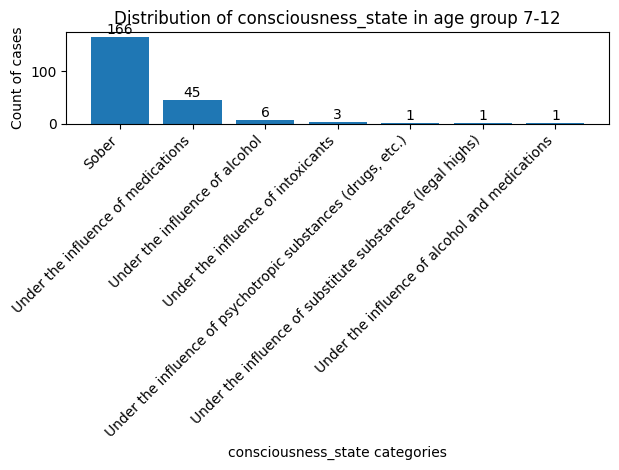

In [946]:
create_bar_plot(
                serie_indexes,
                serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####female

In [947]:
female_serie_indexes = data_age_group.loc[female_index, variable].dropna().value_counts().index.tolist()

In [948]:
female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

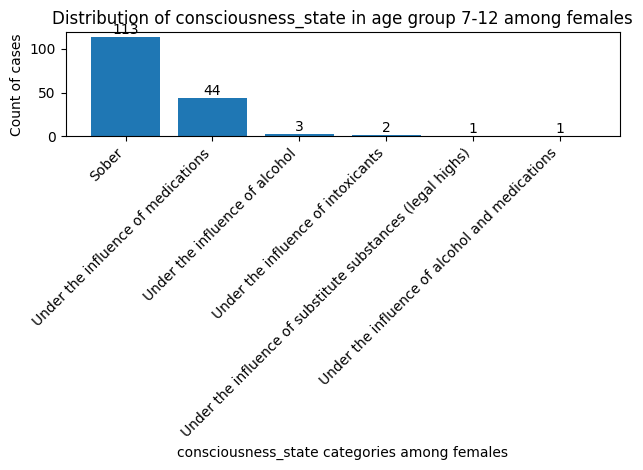

In [949]:
create_bar_plot(
                female_serie_indexes,
                female_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [950]:
female_probabilities = [x / sum(female_serie_values) for x in female_serie_values]

In [951]:
female_null_index = female_index[data_age_group.loc[female_index, variable].isnull()]


In [952]:
data_age_group.loc[female_null_index, variable] = np.random.choice(female_serie_indexes, size=len(female_null_index.tolist()), p=female_probabilities)

#####male

In [953]:
male_serie_indexes = data_age_group.loc[male_index, variable].dropna().value_counts().index.tolist()

In [954]:
male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

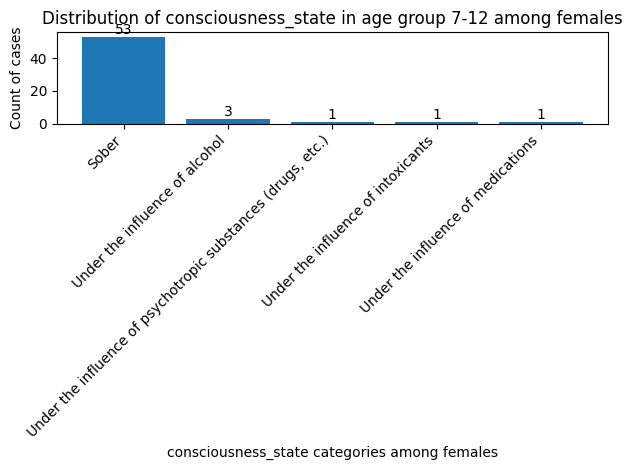

In [955]:
create_bar_plot(
                male_serie_indexes,
                male_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [956]:
male_probabilities = [x / sum(male_serie_values) for x in male_serie_values]

In [957]:
male_null_index = male_index[data_age_group.loc[male_index, variable].isnull()]


In [958]:
data_age_group.loc[male_null_index, variable] = np.random.choice(male_serie_indexes, size=len(male_null_index.tolist()), p=male_probabilities)

##### Summary

In [959]:
new_female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


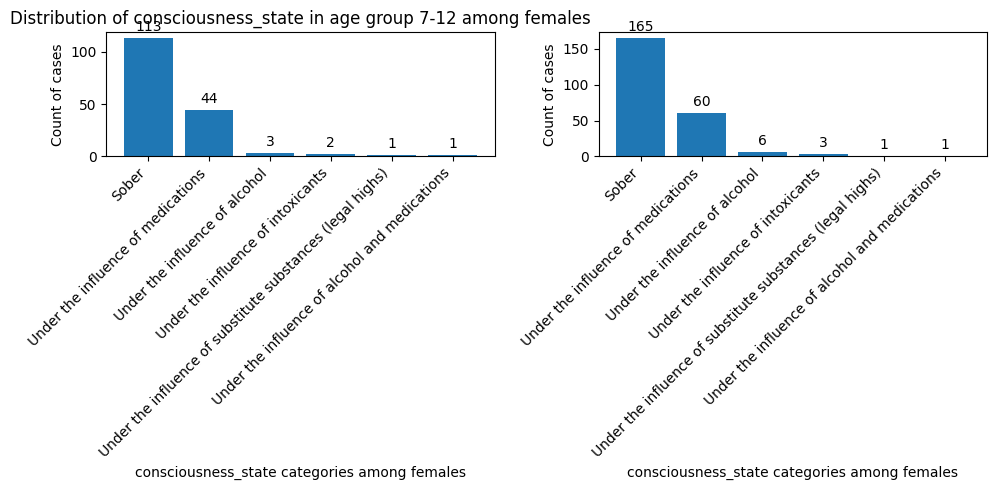

In [960]:
create_double_bar_plot(
                      female_serie_indexes,
                      female_serie_values,
                      new_female_serie_values,
                      variable + ' categories' + ' among females',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                      x_rotation=45)

In [961]:
new_male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


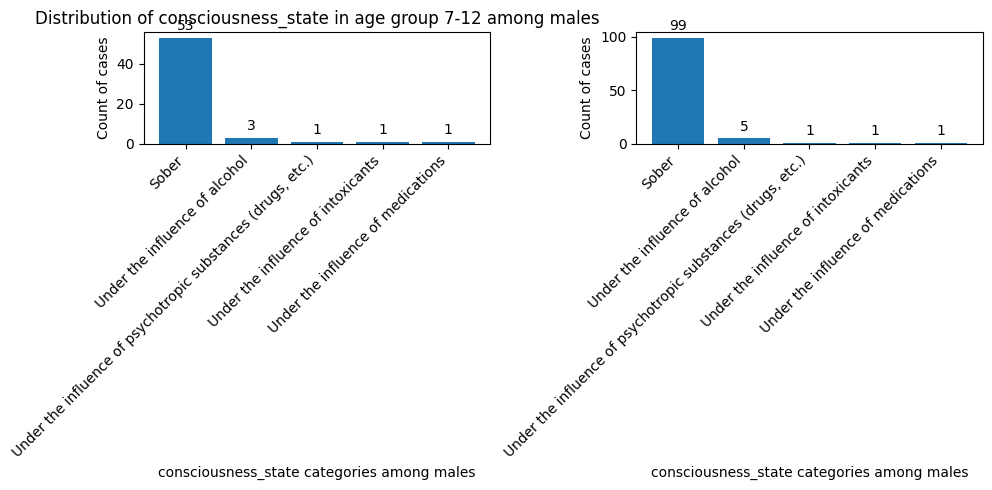

In [962]:
create_double_bar_plot(
                      male_serie_indexes,
                      male_serie_values,
                      new_male_serie_values,
                      variable + ' categories' + ' among males',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                      x_rotation=45)

In [963]:
new_serie_values = data_age_group[variable].value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


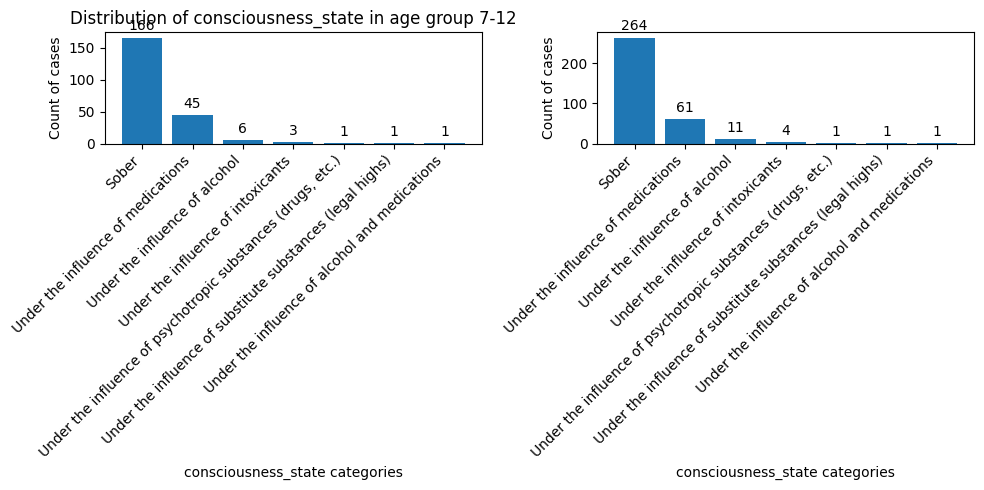

In [964]:
create_double_bar_plot(
                serie_indexes,
                serie_values,
                new_serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - education

In [965]:
variable = 'education'

In [966]:
display_info(data_age_group, [variable])

['education']
1

Mode:
0    Incomplete primary education
Name: education, dtype: object

NaN count: 44

Unique values len:
4

Unique values:
['Primary education' 'Incomplete primary education' nan
 'Lower secondary education']

Value counts:
Incomplete primary education    194
Primary education               103
Lower secondary education         2
Name: education, dtype: int64



In [967]:
serie_values = data_age_group[variable].dropna().value_counts().values.tolist()

In [968]:
serie_indexes = data_age_group[variable].dropna().value_counts().index.tolist()

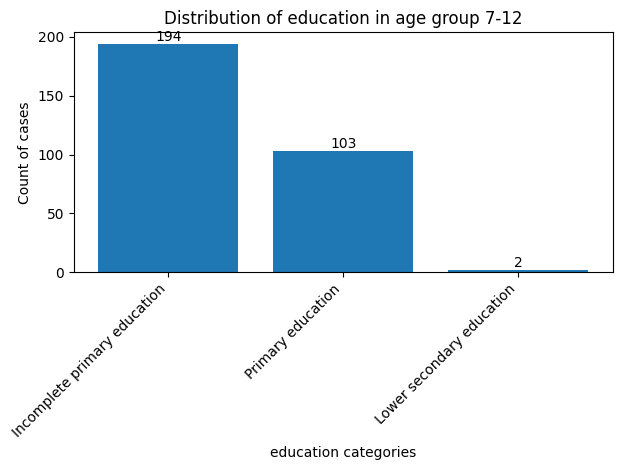

In [969]:
create_bar_plot(
                serie_indexes,
                serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####female

In [970]:
female_serie_indexes = data_age_group.loc[female_index, variable].dropna().value_counts().index.tolist()

In [971]:
female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

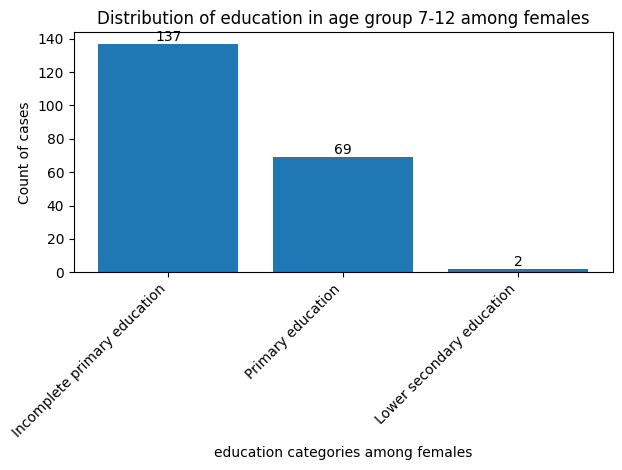

In [972]:
create_bar_plot(
                female_serie_indexes,
                female_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [973]:
female_probabilities = [x / sum(female_serie_values) for x in female_serie_values]

In [974]:
female_null_index = female_index[data_age_group.loc[female_index, variable].isnull()]


In [975]:
data_age_group.loc[female_null_index, variable] = np.random.choice(female_serie_indexes, size=len(female_null_index.tolist()), p=female_probabilities)

#####male

In [976]:
male_serie_indexes = data_age_group.loc[male_index, variable].dropna().value_counts().index.tolist()

In [977]:
male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

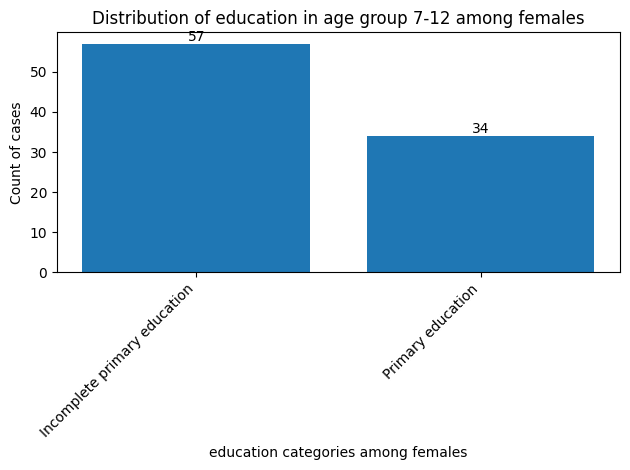

In [978]:
create_bar_plot(
                male_serie_indexes,
                male_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [979]:
male_probabilities = [x / sum(male_serie_values) for x in male_serie_values]

In [980]:
male_null_index = male_index[data_age_group.loc[male_index, variable].isnull()]


In [981]:
data_age_group.loc[male_null_index, variable] = np.random.choice(male_serie_indexes, size=len(male_null_index.tolist()), p=male_probabilities)

##### Summary

In [982]:
new_female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


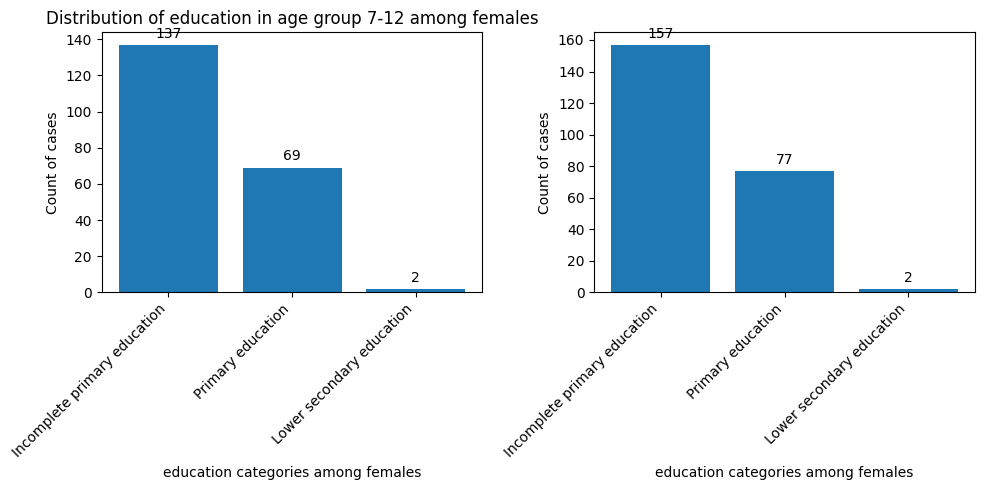

In [983]:
create_double_bar_plot(
                      female_serie_indexes,
                      female_serie_values,
                      new_female_serie_values,
                      variable + ' categories' + ' among females',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                      x_rotation=45)

In [984]:
new_male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


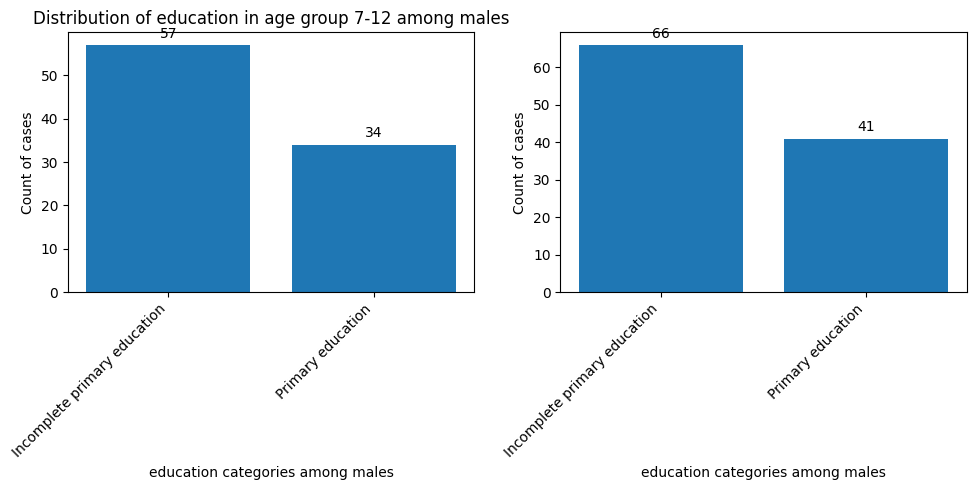

In [985]:
create_double_bar_plot(
                      male_serie_indexes,
                      male_serie_values,
                      new_male_serie_values,
                      variable + ' categories' + ' among males',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                      x_rotation=45)

In [986]:
new_serie_values = data_age_group[variable].value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


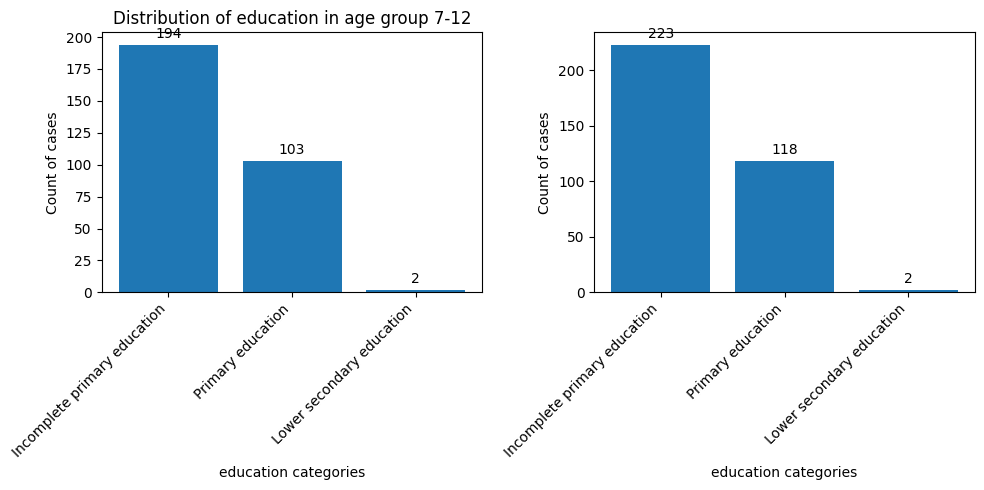

In [987]:
create_double_bar_plot(
                serie_indexes,
                serie_values,
                new_serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - livelihood_source

In [988]:
variable = 'livelihood_source'

In [989]:
display_info(data_age_group, [variable])

['livelihood_source']
1

Mode:
0    Dependent on another person
Name: livelihood_source, dtype: object

NaN count: 17

Unique values len:
4

Unique values:
['Dependent on another person' nan 'Employed'
 'No regular source of maintenance']

Value counts:
Dependent on another person         323
No regular source of maintenance      2
Employed                              1
Name: livelihood_source, dtype: int64



In [990]:
serie_values = data_age_group[variable].dropna().value_counts().values.tolist()

In [991]:
serie_indexes = data_age_group[variable].dropna().value_counts().index.tolist()

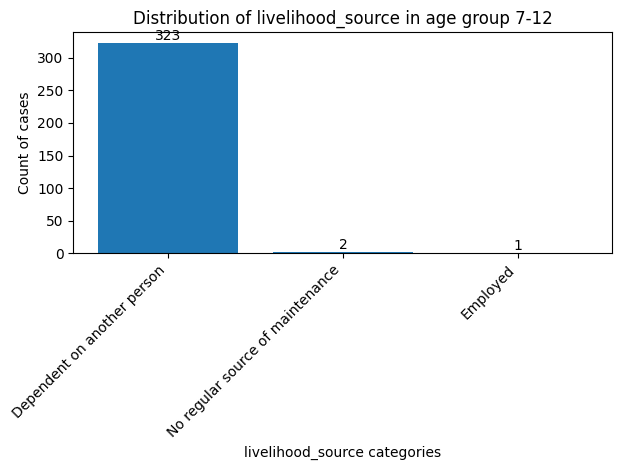

In [992]:
create_bar_plot(
                serie_indexes,
                serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####female

In [993]:
female_serie_indexes = data_age_group.loc[female_index, variable].dropna().value_counts().index.tolist()

In [994]:
female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

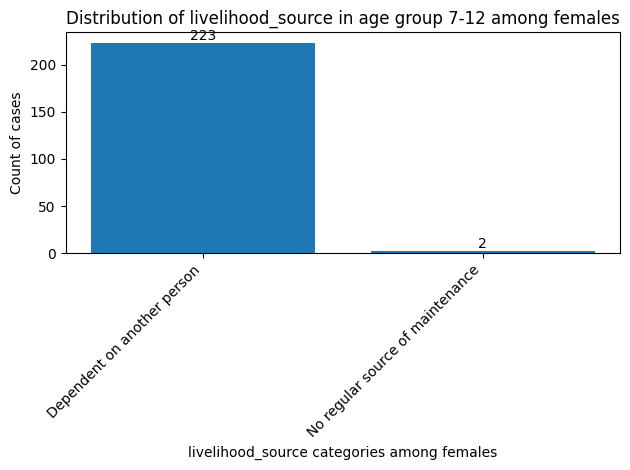

In [995]:
create_bar_plot(
                female_serie_indexes,
                female_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [996]:
female_probabilities = [x / sum(female_serie_values) for x in female_serie_values]

In [997]:
female_null_index = female_index[data_age_group.loc[female_index, variable].isnull()]


In [998]:
data_age_group.loc[female_null_index, variable] = np.random.choice(female_serie_indexes, size=len(female_null_index.tolist()), p=female_probabilities)

#####male

In [999]:
male_serie_indexes = data_age_group.loc[male_index, variable].dropna().value_counts().index.tolist()

In [1000]:
male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

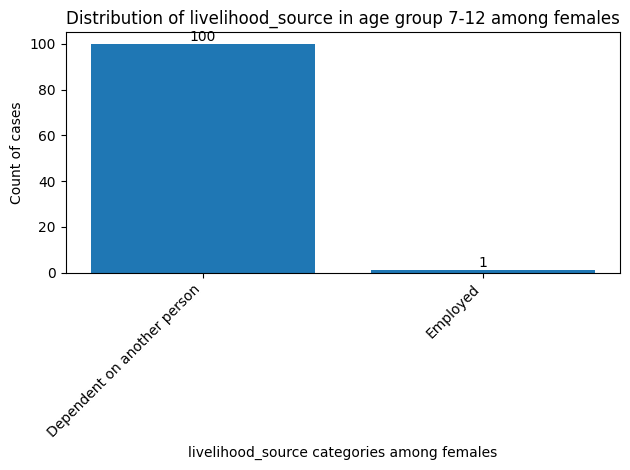

In [1001]:
create_bar_plot(
                male_serie_indexes,
                male_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [1002]:
male_probabilities = [x / sum(male_serie_values) for x in male_serie_values]

In [1003]:
male_null_index = male_index[data_age_group.loc[male_index, variable].isnull()]


In [1004]:
data_age_group.loc[male_null_index, variable] = np.random.choice(male_serie_indexes, size=len(male_null_index.tolist()), p=male_probabilities)

##### Summary

In [1005]:
new_female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


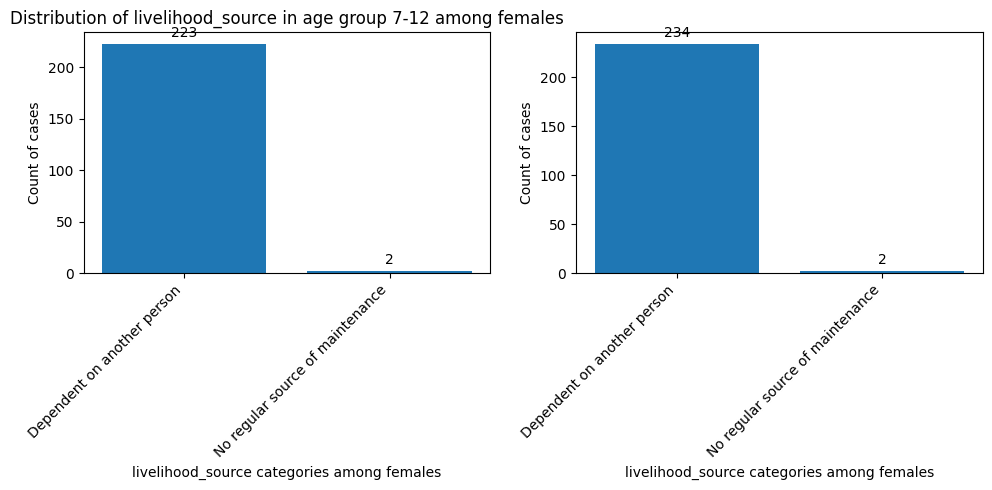

In [1006]:
create_double_bar_plot(
                      female_serie_indexes,
                      female_serie_values,
                      new_female_serie_values,
                      variable + ' categories' + ' among females',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                      x_rotation=45)

In [1007]:
new_male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


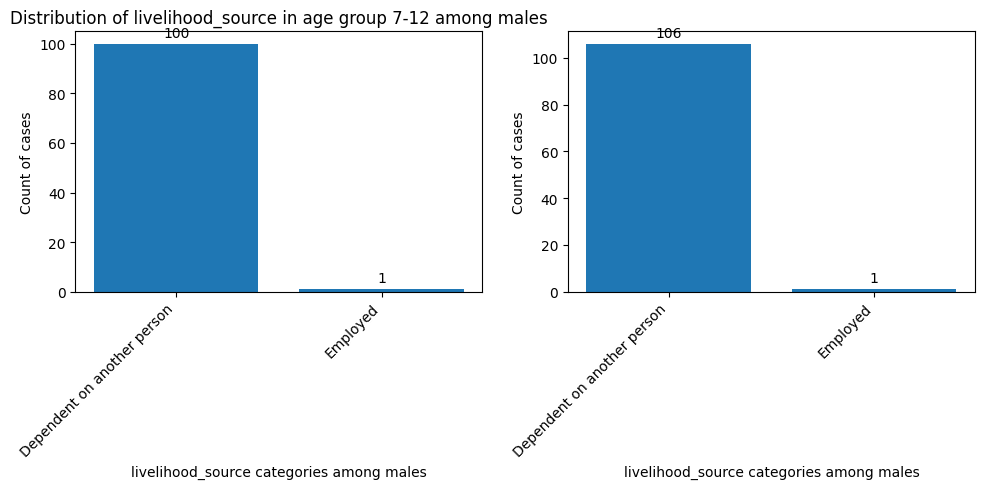

In [1008]:
create_double_bar_plot(
                      male_serie_indexes,
                      male_serie_values,
                      new_male_serie_values,
                      variable + ' categories' + ' among males',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                      x_rotation=45)

In [1009]:
new_serie_values = data_age_group[variable].value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


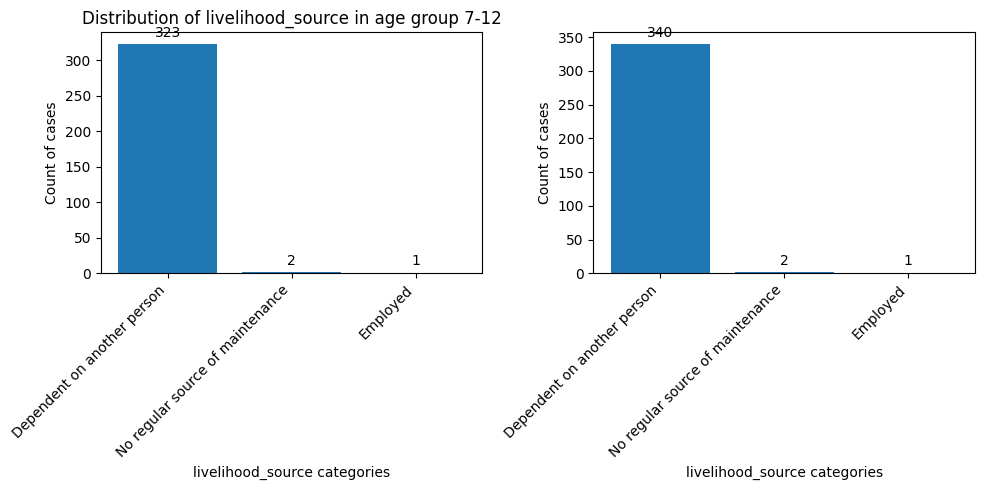

In [1010]:
create_double_bar_plot(
                serie_indexes,
                serie_values,
                new_serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - work_study_info

In [1011]:
variable = 'work_study_info'

In [1012]:
display_info(data_age_group, [variable])

['work_study_info']
1

Mode:
0    Student
Name: work_study_info, dtype: object

NaN count: 12

Unique values len:
4

Unique values:
['Student' 'Blue-collar worker' nan 'Unemployed']

Value counts:
Student               329
Blue-collar worker      1
Unemployed              1
Name: work_study_info, dtype: int64



In [1013]:
serie_values = data_age_group[variable].dropna().value_counts().values.tolist()

In [1014]:
serie_indexes = data_age_group[variable].dropna().value_counts().index.tolist()

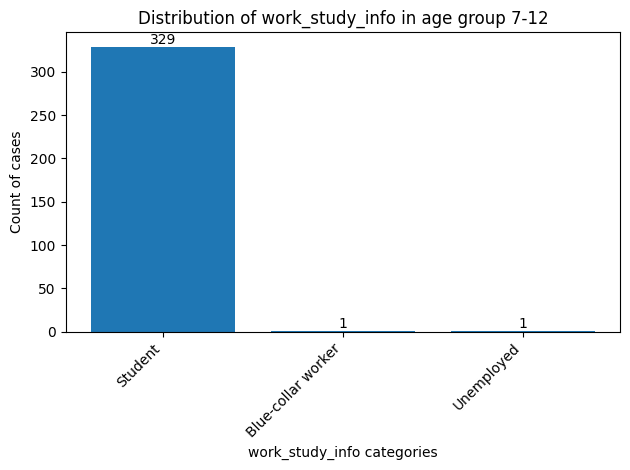

In [1015]:
create_bar_plot(
                serie_indexes,
                serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####female

In [1016]:
female_serie_indexes = data_age_group.loc[female_index, variable].dropna().value_counts().index.tolist()

In [1017]:
female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

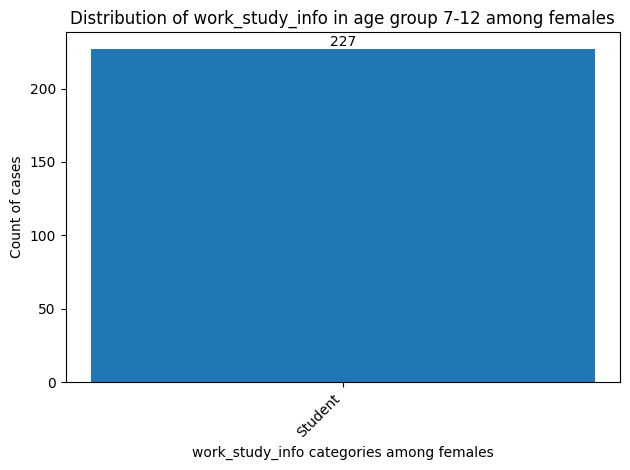

In [1018]:
create_bar_plot(
                female_serie_indexes,
                female_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [1019]:
female_probabilities = [x / sum(female_serie_values) for x in female_serie_values]

In [1020]:
female_null_index = female_index[data_age_group.loc[female_index, variable].isnull()]


In [1021]:
data_age_group.loc[female_null_index, variable] = np.random.choice(female_serie_indexes, size=len(female_null_index.tolist()), p=female_probabilities)

#####male

In [1022]:
male_serie_indexes = data_age_group.loc[male_index, variable].dropna().value_counts().index.tolist()

In [1023]:
male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

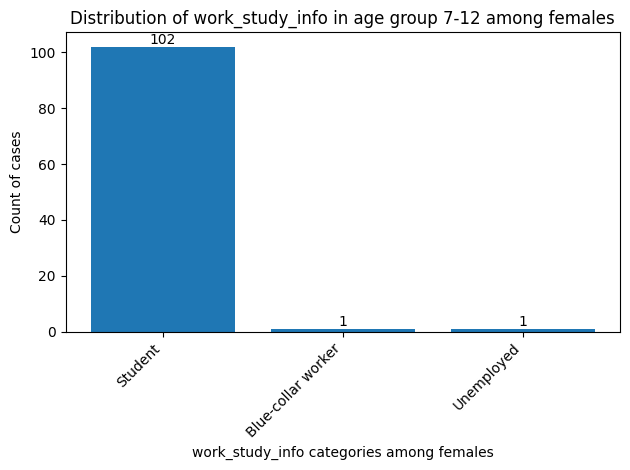

In [1024]:
create_bar_plot(
                male_serie_indexes,
                male_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [1025]:
male_probabilities = [x / sum(male_serie_values) for x in male_serie_values]

In [1026]:
male_null_index = male_index[data_age_group.loc[male_index, variable].isnull()]


In [1027]:
data_age_group.loc[male_null_index, variable] = np.random.choice(male_serie_indexes, size=len(male_null_index.tolist()), p=male_probabilities)

##### Summary

In [1028]:
new_female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


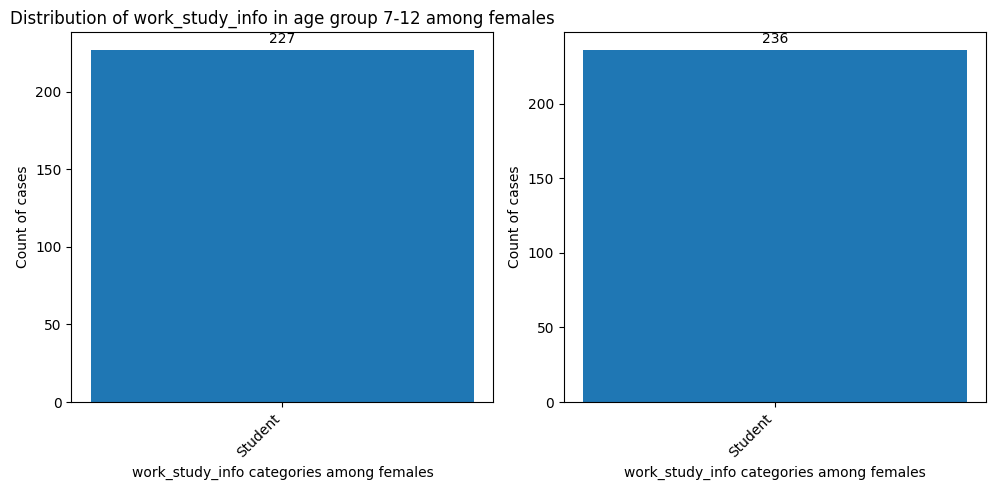

In [1029]:
create_double_bar_plot(
                      female_serie_indexes,
                      female_serie_values,
                      new_female_serie_values,
                      variable + ' categories' + ' among females',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                      x_rotation=45)

In [1030]:
new_male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


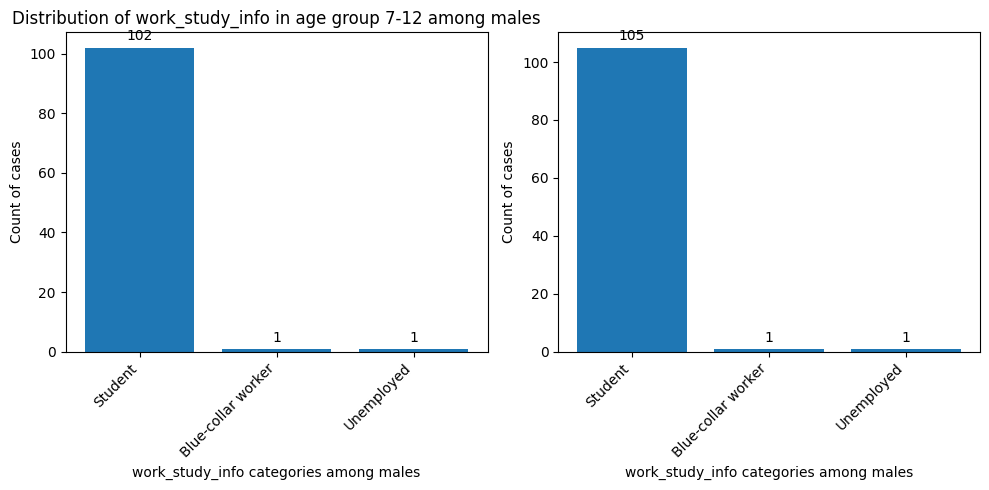

In [1031]:
create_double_bar_plot(
                      male_serie_indexes,
                      male_serie_values,
                      new_male_serie_values,
                      variable + ' categories' + ' among males',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                      x_rotation=45)

In [1032]:
new_serie_values = data_age_group[variable].value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


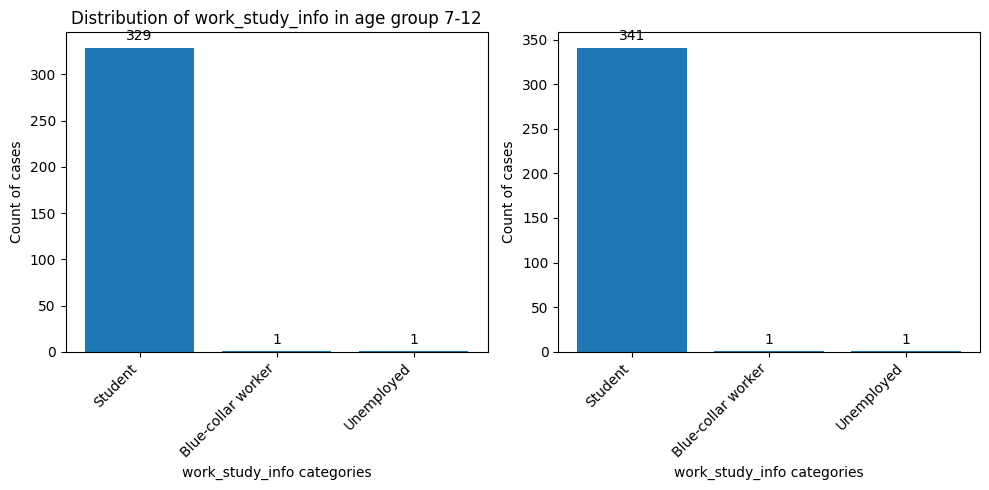

In [1033]:
create_double_bar_plot(
                serie_indexes,
                serie_values,
                new_serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - marital_status

In [1034]:
variable = 'marital_status'

In [1035]:
display_info(data_age_group, [variable])

['marital_status']
1

Mode:
0    Single
Name: marital_status, dtype: object

NaN count: 6

Unique values len:
2

Unique values:
['Single' nan]

Value counts:
Single    337
Name: marital_status, dtype: int64



In [1036]:
serie_values = data_age_group[variable].dropna().value_counts().values.tolist()

In [1037]:
serie_indexes = data_age_group[variable].dropna().value_counts().index.tolist()

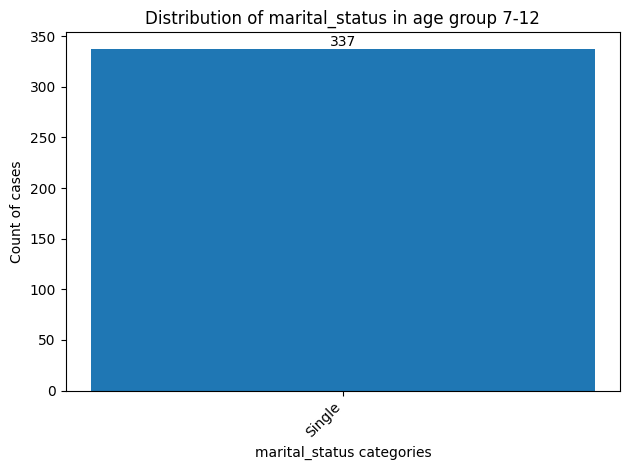

In [1038]:
create_bar_plot(
                serie_indexes,
                serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####female

In [1039]:
female_serie_indexes = data_age_group.loc[female_index, variable].dropna().value_counts().index.tolist()

In [1040]:
female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

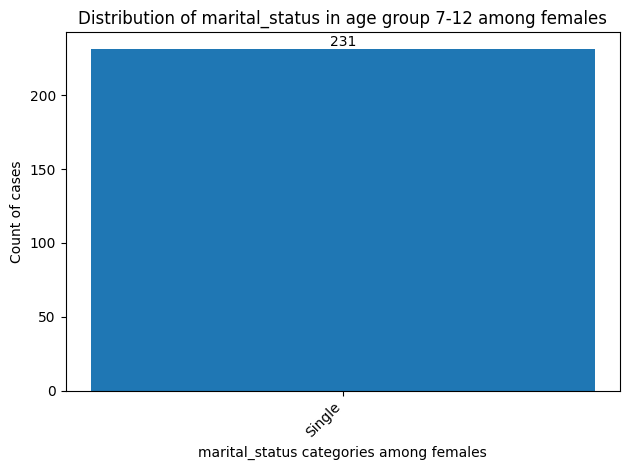

In [1041]:
create_bar_plot(
                female_serie_indexes,
                female_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [1042]:
female_probabilities = [x / sum(female_serie_values) for x in female_serie_values]

In [1043]:
female_null_index = female_index[data_age_group.loc[female_index, variable].isnull()]


In [1044]:
data_age_group.loc[female_null_index, variable] = np.random.choice(female_serie_indexes, size=len(female_null_index.tolist()), p=female_probabilities)

#####male

In [1045]:
male_serie_indexes = data_age_group.loc[male_index, variable].dropna().value_counts().index.tolist()

In [1046]:
male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

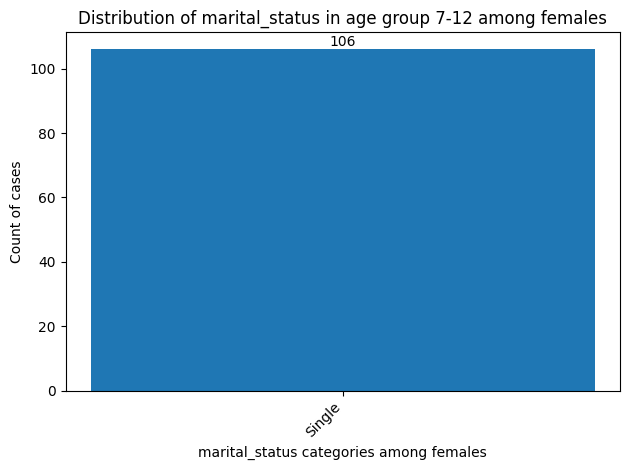

In [1047]:
create_bar_plot(
                male_serie_indexes,
                male_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [1048]:
male_probabilities = [x / sum(male_serie_values) for x in male_serie_values]

In [1049]:
male_null_index = male_index[data_age_group.loc[male_index, variable].isnull()]


In [1050]:
data_age_group.loc[male_null_index, variable] = np.random.choice(male_serie_indexes, size=len(male_null_index.tolist()), p=male_probabilities)

##### Summary

In [1051]:
new_female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


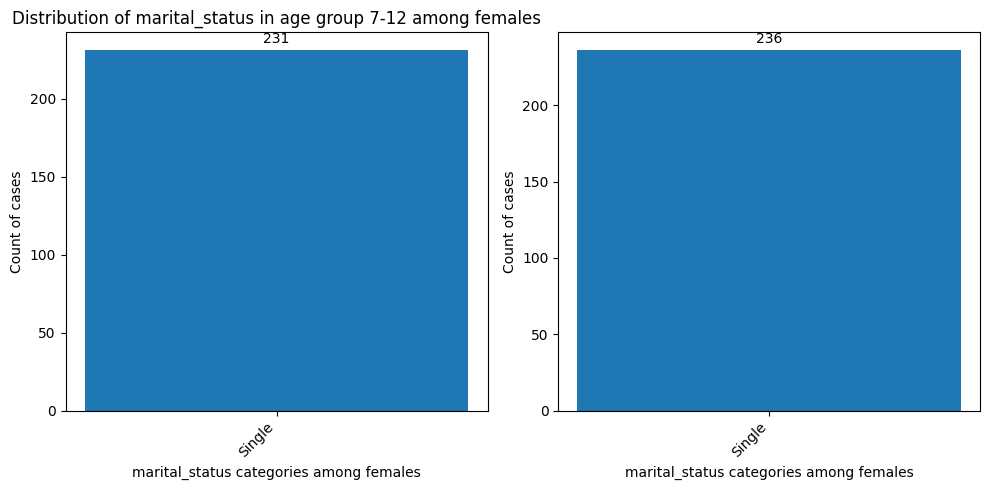

In [1052]:
create_double_bar_plot(
                      female_serie_indexes,
                      female_serie_values,
                      new_female_serie_values,
                      variable + ' categories' + ' among females',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                      x_rotation=45)

In [1053]:
new_male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


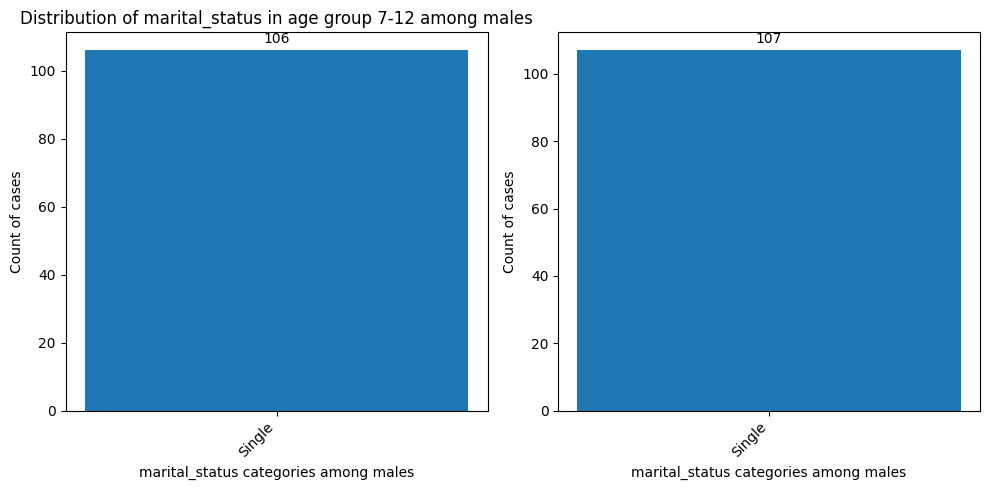

In [1054]:
create_double_bar_plot(
                      male_serie_indexes,
                      male_serie_values,
                      new_male_serie_values,
                      variable + ' categories' + ' among males',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                      x_rotation=45)

In [1055]:
new_serie_values = data_age_group[variable].value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


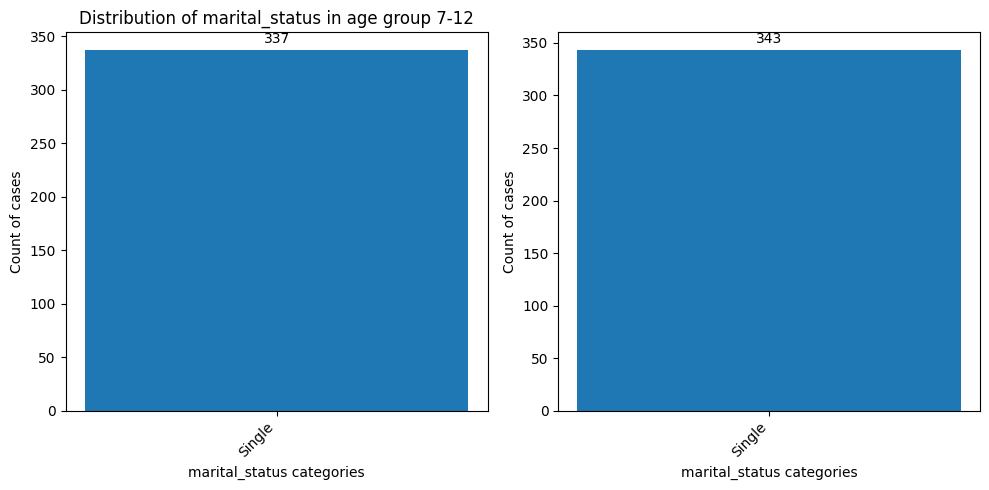

In [1056]:
create_double_bar_plot(
                serie_indexes,
                serie_values,
                new_serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - consciousness_state

In [1057]:
variable = 'consciousness_state'

In [1058]:
display_info(data_age_group, [variable])

['consciousness_state']
1

Mode:
0    Sober
Name: consciousness_state, dtype: object

NaN count: 0

Unique values len:
7

Unique values:
['Under the influence of alcohol' 'Sober'
 'Under the influence of medications'
 'Under the influence of psychotropic substances (drugs, etc.)'
 'Under the influence of substitute substances (legal highs)'
 'Under the influence of intoxicants'
 'Under the influence of alcohol and medications']

Value counts:
Sober                                                           264
Under the influence of medications                               61
Under the influence of alcohol                                   11
Under the influence of intoxicants                                4
Under the influence of psychotropic substances (drugs, etc.)      1
Under the influence of substitute substances (legal highs)        1
Under the influence of alcohol and medications                    1
Name: consciousness_state, dtype: int64



In [1059]:
serie_values = data_age_group[variable].dropna().value_counts().values.tolist()

In [1060]:
serie_indexes = data_age_group[variable].dropna().value_counts().index.tolist()

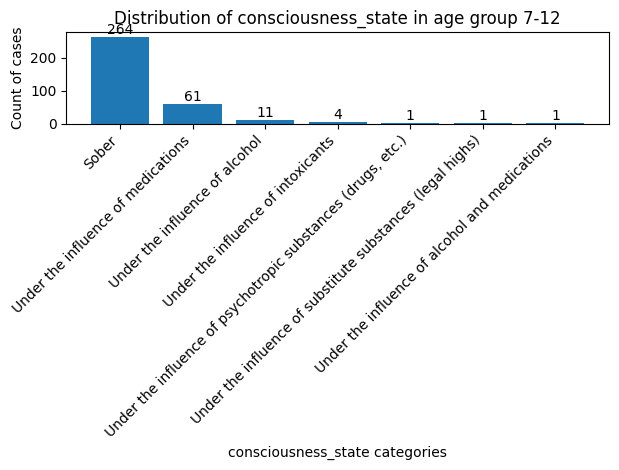

In [1061]:
create_bar_plot(
                serie_indexes,
                serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####female

In [1062]:
female_serie_indexes = data_age_group.loc[female_index, variable].dropna().value_counts().index.tolist()

In [1063]:
female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

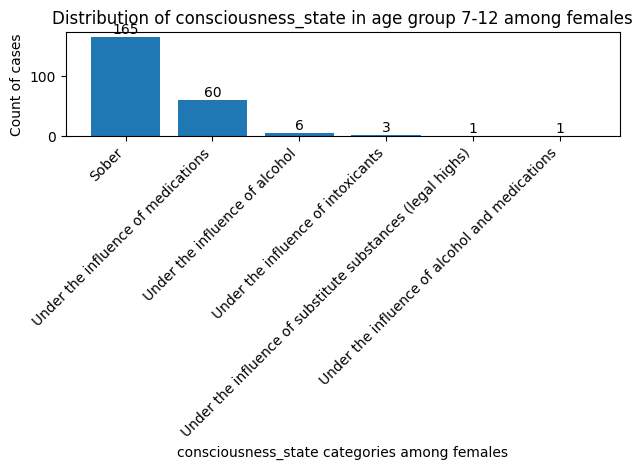

In [1064]:
create_bar_plot(
                female_serie_indexes,
                female_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [1065]:
female_probabilities = [x / sum(female_serie_values) for x in female_serie_values]

In [1066]:
female_null_index = female_index[data_age_group.loc[female_index, variable].isnull()]


In [1067]:
data_age_group.loc[female_null_index, variable] = np.random.choice(female_serie_indexes, size=len(female_null_index.tolist()), p=female_probabilities)

#####male

In [1068]:
male_serie_indexes = data_age_group.loc[male_index, variable].dropna().value_counts().index.tolist()

In [1069]:
male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

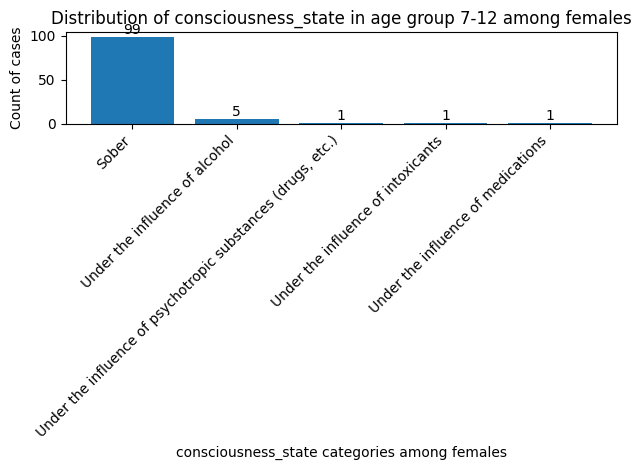

In [1070]:
create_bar_plot(
                male_serie_indexes,
                male_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [1071]:
male_probabilities = [x / sum(male_serie_values) for x in male_serie_values]

In [1072]:
male_null_index = male_index[data_age_group.loc[male_index, variable].isnull()]


In [1073]:
data_age_group.loc[male_null_index, variable] = np.random.choice(male_serie_indexes, size=len(male_null_index.tolist()), p=male_probabilities)

##### Summary

In [1074]:
new_female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


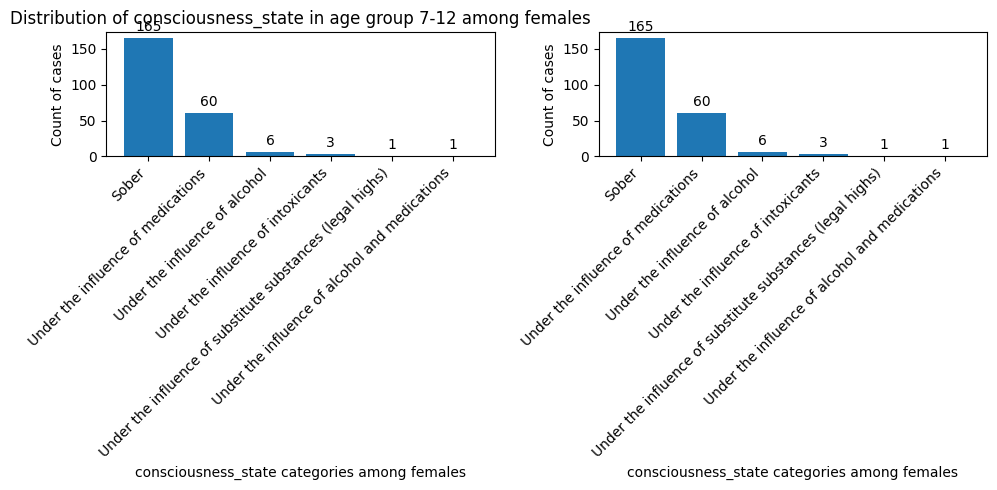

In [1075]:
create_double_bar_plot(
                      female_serie_indexes,
                      female_serie_values,
                      new_female_serie_values,
                      variable + ' categories' + ' among females',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                      x_rotation=45)

In [1076]:
new_male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


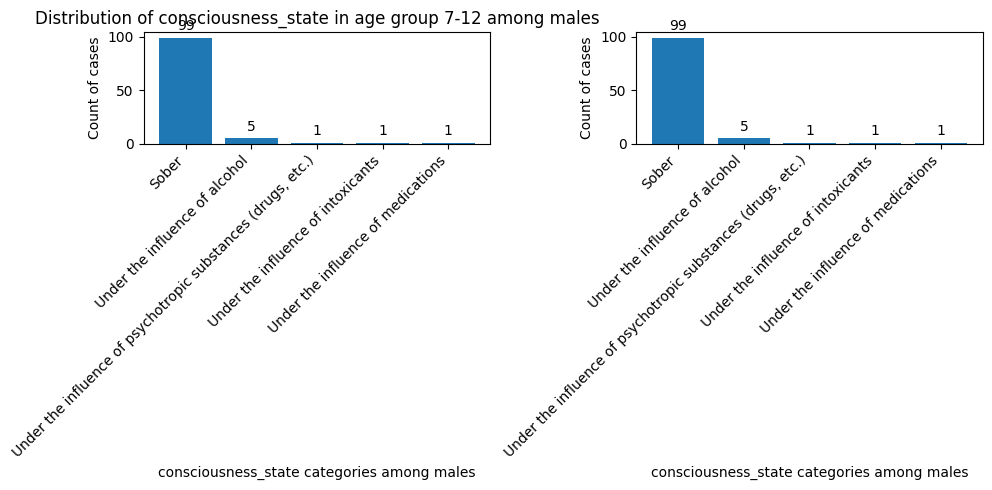

In [1077]:
create_double_bar_plot(
                      male_serie_indexes,
                      male_serie_values,
                      new_male_serie_values,
                      variable + ' categories' + ' among males',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                      x_rotation=45)

In [1078]:
new_serie_values = data_age_group[variable].value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


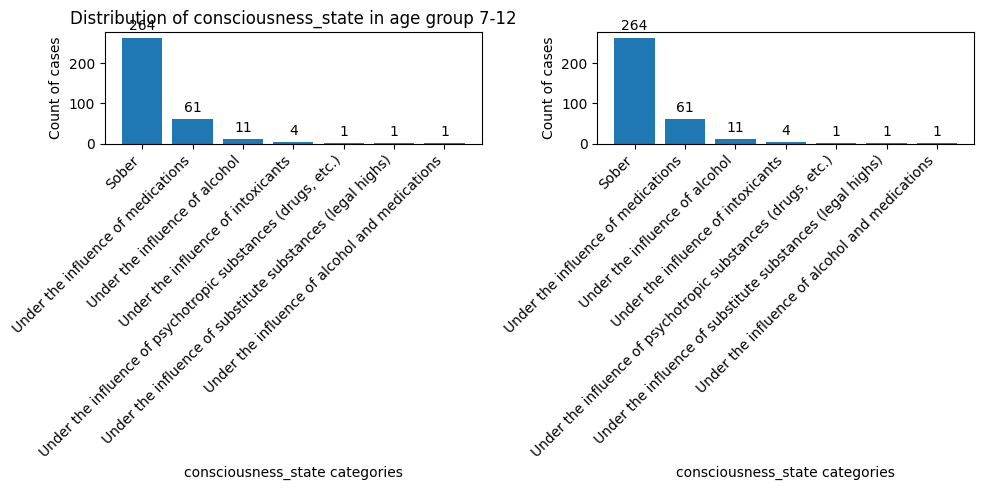

In [1079]:
create_double_bar_plot(
                serie_indexes,
                serie_values,
                new_serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

####Variable - reason_of_attack_count

In [1080]:
variable = 'reason_of_attack_count'

In [1081]:
display_info(data_age_group, [variable])

['reason_of_attack_count']
1

Mode:
0    1.0
Name: reason_of_attack_count, dtype: float64

NaN count: 85

Unique values len:
4

Unique values:
[ 1. nan  2.  3.]

Value counts:
1.0    204
2.0     49
3.0      5
Name: reason_of_attack_count, dtype: int64



In [1082]:
serie_values = data_age_group[variable].dropna().value_counts().values.tolist()

In [1083]:
serie_indexes = data_age_group[variable].dropna().value_counts().index.tolist()

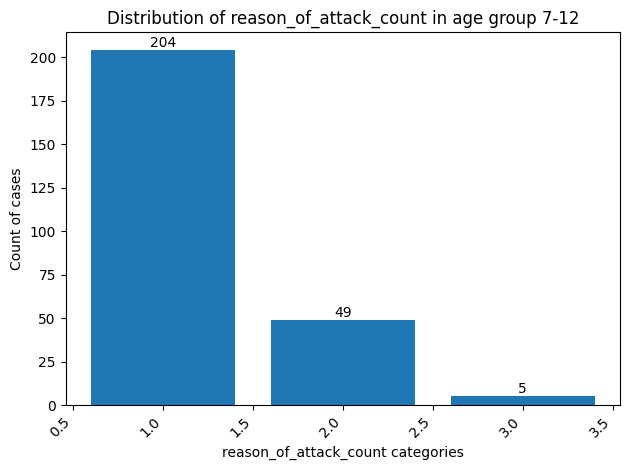

In [1084]:
create_bar_plot(
                serie_indexes,
                serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

#####female

In [1085]:
female_serie_indexes = data_age_group.loc[female_index, variable].dropna().value_counts().index.tolist()

In [1086]:
female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

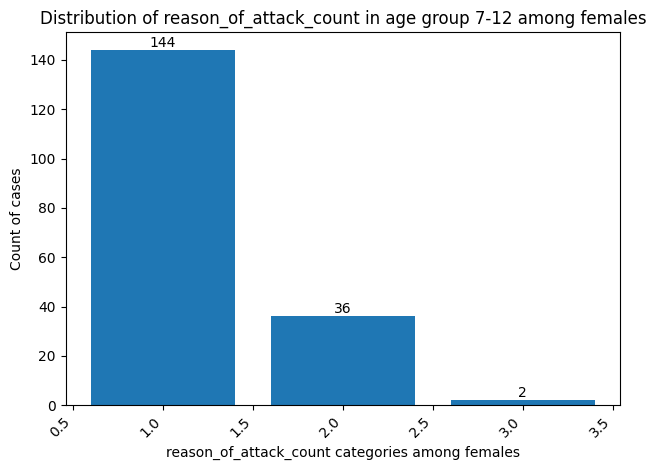

In [1087]:
create_bar_plot(
                female_serie_indexes,
                female_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [1088]:
female_probabilities = [x / sum(female_serie_values) for x in female_serie_values]

In [1089]:
female_null_index = female_index[data_age_group.loc[female_index, variable].isnull()]


In [1090]:
data_age_group.loc[female_null_index, variable] = np.random.choice(female_serie_indexes, size=len(female_null_index.tolist()), p=female_probabilities)

#####male

In [1091]:
male_serie_indexes = data_age_group.loc[male_index, variable].dropna().value_counts().index.tolist()

In [1092]:
male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

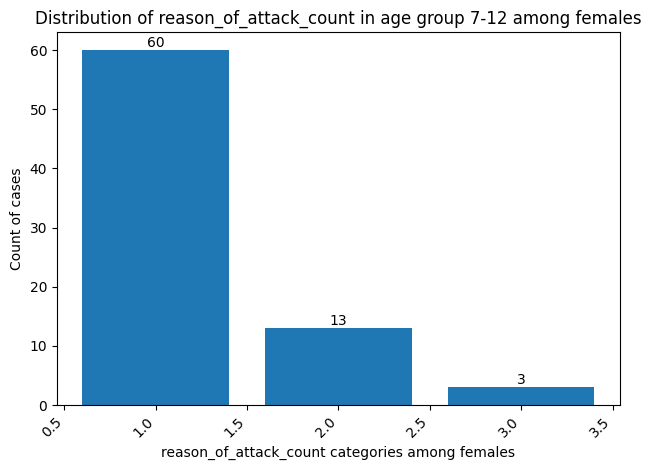

In [1093]:
create_bar_plot(
                male_serie_indexes,
                male_serie_values,
                variable + ' categories' + ' among females',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [1094]:
male_probabilities = [x / sum(male_serie_values) for x in male_serie_values]

In [1095]:
male_null_index = male_index[data_age_group.loc[male_index, variable].isnull()]


In [1096]:
data_age_group.loc[male_null_index, variable] = np.random.choice(male_serie_indexes, size=len(male_null_index.tolist()), p=male_probabilities)

##### Summary

In [1097]:
new_female_serie_values = data_age_group.loc[female_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


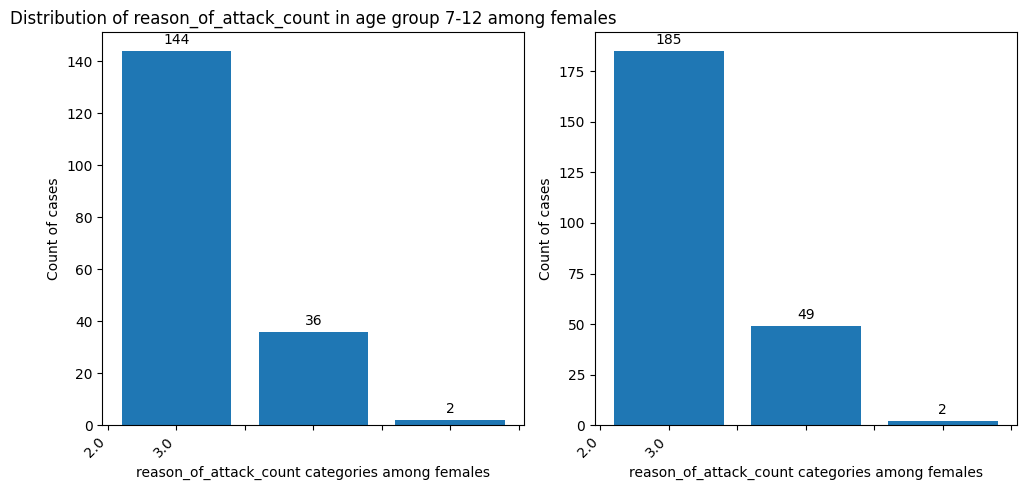

In [1098]:
create_double_bar_plot(
                      female_serie_indexes,
                      female_serie_values,
                      new_female_serie_values,
                      variable + ' categories' + ' among females',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among females',
                      x_rotation=45)

In [1099]:
new_male_serie_values = data_age_group.loc[male_index, variable].dropna().value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


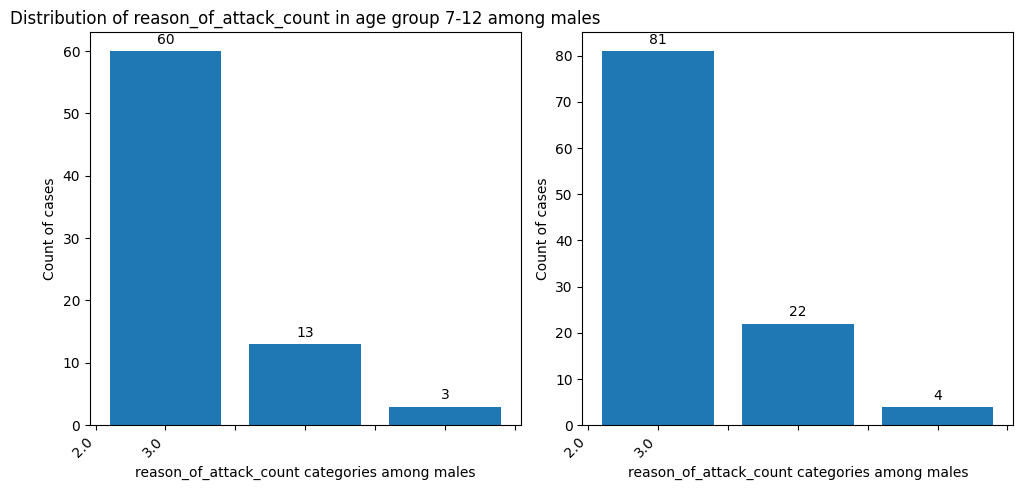

In [1100]:
create_double_bar_plot(
                      male_serie_indexes,
                      male_serie_values,
                      new_male_serie_values,
                      variable + ' categories' + ' among males',
                      'Count of cases',
                      'Distribution of ' + variable + ' in age group ' + age_group + ' among males',
                      x_rotation=45)

In [1101]:
new_serie_values = data_age_group[variable].value_counts().values.tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


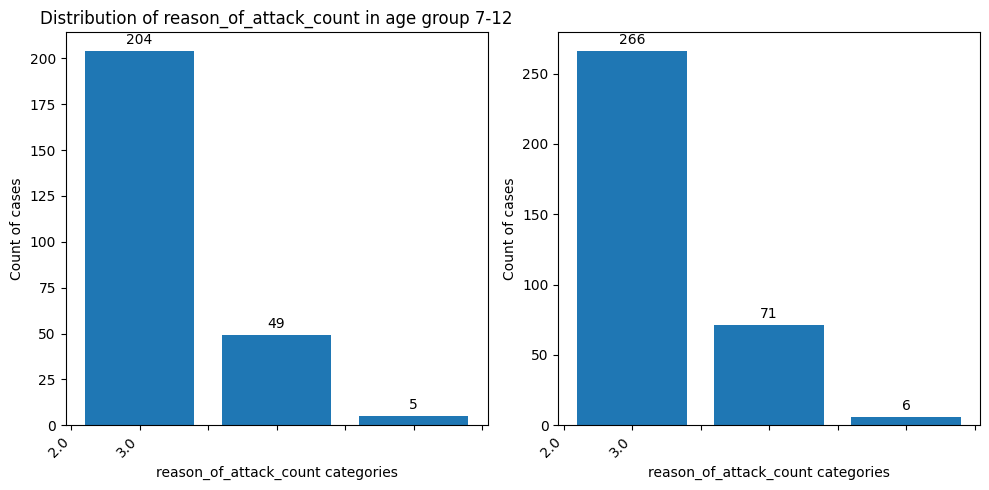

In [1102]:
create_double_bar_plot(
                serie_indexes,
                serie_values,
                new_serie_values,
                variable + ' categories',
                'Count of cases',
                'Distribution of ' + variable + ' in age group ' + age_group,
                x_rotation=45)

##### data_age_group_7_12_reasons_of_attack

In [1103]:
serie_indexes = data_age_group_reasons_of_attack.columns.tolist()

In [1104]:
serie_values = data_age_group_reasons_of_attack[selected_columns].sum().tolist()

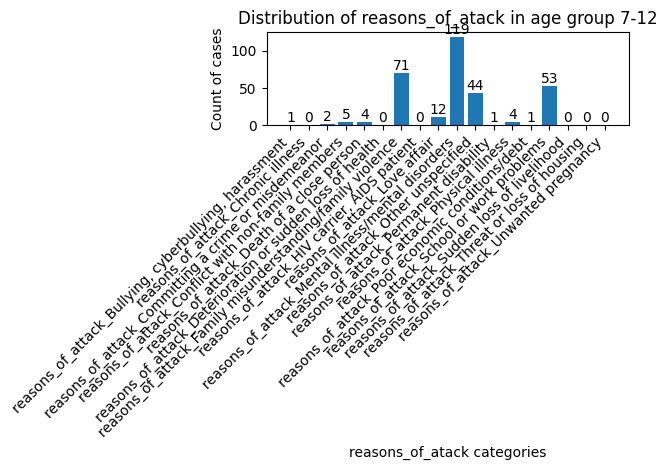

In [1105]:
create_bar_plot(
                serie_indexes,
                serie_values,
                'reasons_of_atack' + ' categories',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group,
                x_rotation=45)

###### female

In [1106]:
female_series = data_age_group_reasons_of_attack.loc[female_index, serie_indexes].sum().tolist()

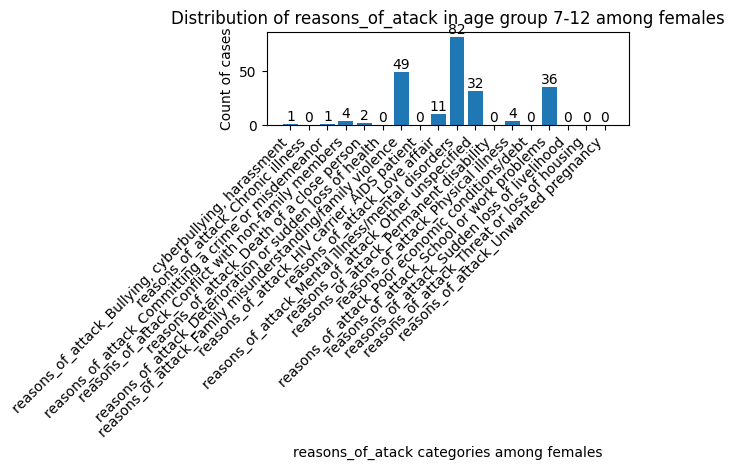

In [1107]:
create_bar_plot(
                serie_indexes,
                female_series,
                'reasons_of_atack categories among females',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group + ' among females',
                x_rotation=45)

In [1108]:
female_probabilities = [x / sum(female_series) for x in female_series]

In [1109]:
# Lista do przechowywania wylosowanych wartości dla każdej wartości w zmiennej
selected_values = []

# Iteracja przez wartości w zmiennej
for value in data_age_group.loc[female_null_index, variable]:
    # Losowanie wartości zgodnie z podanymi prawdopodobieństwami
    selected_value = np.random.choice(serie_indexes, size=int(value), p=female_probabilities)
    selected_values.append(selected_value)

In [1110]:
# Iteracja przez indeksy i wartości w kolumnie reason_of_attack_count
for idx, selected_value in zip(female_null_index, selected_values):
    # Iteracja przez wylosowane wartości
    for column_name in selected_value:
        # Ustawienie wartości 1 w odpowiednich kolumnach
        data_age_group_reasons_of_attack.loc[idx, column_name] = 1


###### male

In [1111]:
male_series = data_age_group_reasons_of_attack.loc[male_index, serie_indexes].sum().tolist()

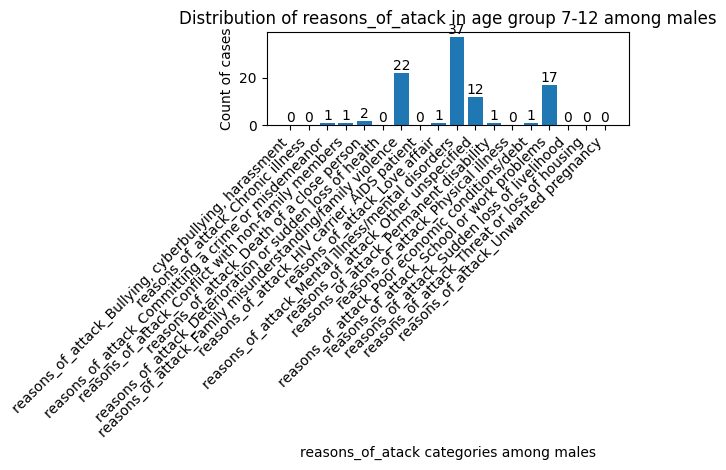

In [1112]:
create_bar_plot(
                serie_indexes,
                male_series,
                'reasons_of_atack categories among males',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group + ' among males',
                x_rotation=45)

In [1113]:
male_probabilities = [x / sum(male_series) for x in male_series]

In [1114]:
# Lista do przechowywania wylosowanych wartości dla każdej wartości w zmiennej
selected_values = []

# Iteracja przez wartości w zmiennej
for value in data_age_group.loc[male_null_index, variable]:
    # Losowanie wartości zgodnie z podanymi prawdopodobieństwami
    selected_value = np.random.choice(serie_indexes, size=int(value), p=male_probabilities)
    selected_values.append(selected_value)

In [1115]:
# Iteracja przez indeksy i wartości w kolumnie reason_of_attack_count
for idx, selected_value in zip(male_null_index, selected_values):
    # Iteracja przez wylosowane wartości
    for column_name in selected_value:
        # Ustawienie wartości 1 w odpowiednich kolumnach
        data_age_group_reasons_of_attack.loc[idx, column_name] = 1


###### Summary

In [1116]:
new_serie_values = data_age_group_reasons_of_attack[selected_columns].sum().tolist()

In [1117]:
new_male_series = data_age_group_reasons_of_attack.loc[male_index, selected_columns].sum().tolist()

In [1118]:
new_female_series = data_age_group_reasons_of_attack.loc[female_index, selected_columns].sum().tolist()

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


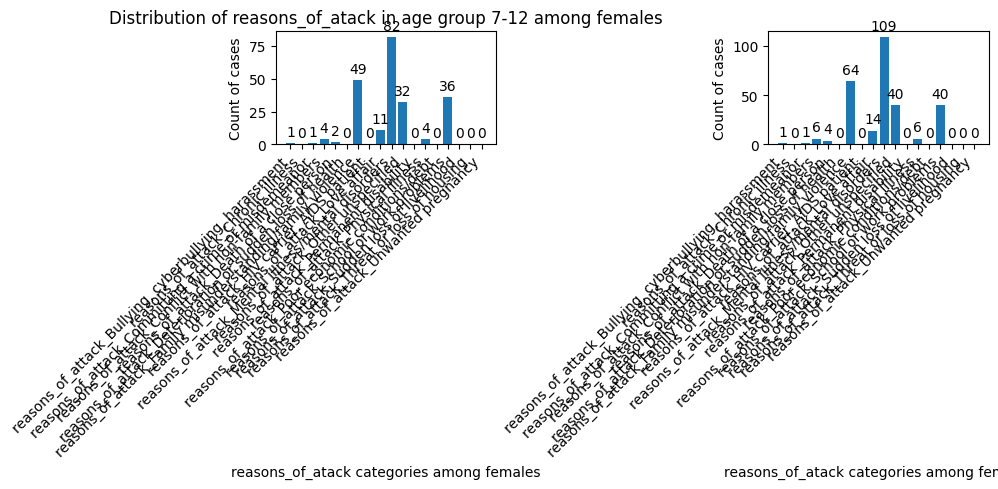

In [1119]:
create_double_bar_plot(
                serie_indexes,
                female_series,
                new_female_series,
                'reasons_of_atack categories among females',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group + ' among females',
                x_rotation=45)

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


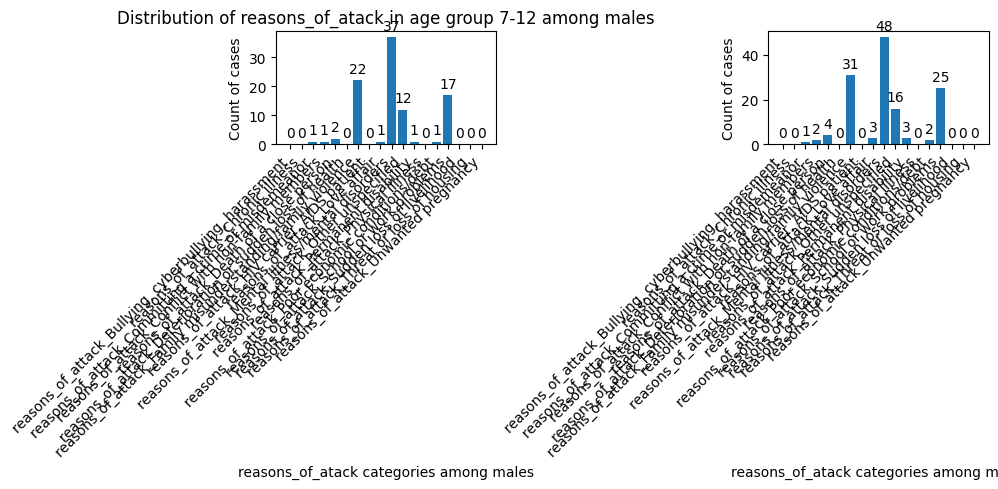

In [1120]:
create_double_bar_plot(
                serie_indexes,
                male_series,
                new_male_series,
                'reasons_of_atack categories among males',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group + ' among males',
                x_rotation=45)

<ipython-input-907-f9e40cd85b5e>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_values, rotation=x_rotation, ha='right')
<ipython-input-907-f9e40cd85b5e>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_values, rotation=x_rotation, ha='right')


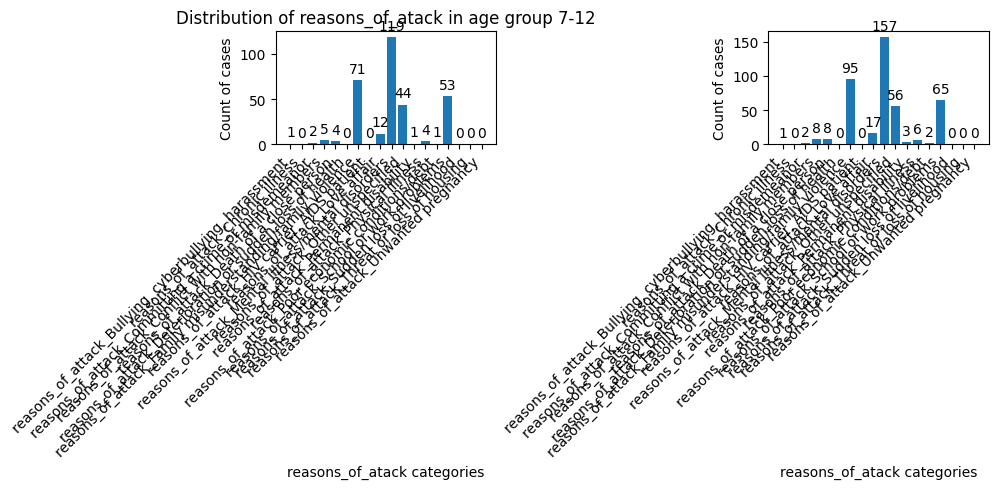

In [1121]:
create_double_bar_plot(
                serie_indexes,
                serie_values,
                new_serie_values,
                'reasons_of_atack categories',
                'Count of cases',
                'Distribution of ' + 'reasons_of_atack' + ' in age group ' + age_group,
                x_rotation=45)

####Summary

In [1122]:
##Brakujące dane
total = data_age_group.isnull().sum().sort_values(ascending=False)
percent = 100*(data_age_group.isnull().sum()/data_age_group.isnull().count()).sort_values(ascending=False)
missing_data_age_group = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [1123]:
missing_data_age_group

,Total,Percent
substance_info,343,100.0
treatment_info,343,100.0
suicide_id,0,0.0
report_date_year,0,0.0
report_date_month,0,0.0
age_group,0,0.0
gender,0,0.0
marital_status,0,0.0
education,0,0.0
work_study_info,0,0.0


In [1124]:
data_age_group = pd.concat([data_age_group, data_age_group_reasons_of_attack], axis=1)

In [1125]:
data_age_group_7_12 = data_age_group.copy()

In [1126]:
data_age_group.drop(columns = ['suicide_id', 'age_group', 'treatment_info', 'substance_info'],axis=1, inplace=True, errors='ignore')

In [1127]:
data_age_group.head()

,report_date_year,report_date_month,gender,marital_status,education,work_study_info,livelihood_source,is_fatal,location_of_attack,method_of_committing,consciousness_state,reason_of_attack_count,"reasons_of_attack_Bullying, cyberbullying, harassment",reasons_of_attack_Chronic illness,reasons_of_attack_Committing a crime or misdemeanor,reasons_of_attack_Conflict with non-family members,reasons_of_attack_Death of a close person,reasons_of_attack_Deterioration or sudden loss of health,reasons_of_attack_Family misunderstanding/family violence,"reasons_of_attack_HIV carrier, AIDS patient",reasons_of_attack_Love affair,reasons_of_attack_Mental illness/mental disorders,reasons_of_attack_Other unspecified,reasons_of_attack_Permanent disability,reasons_of_attack_Physical illness,reasons_of_attack_Poor economic conditions/debt,reasons_of_attack_School or work problems,reasons_of_attack_Sudden loss of livelihood,reasons_of_attack_Threat or loss of housing,reasons_of_attack_Unwanted pregnancy
2707,2013,5,female,Single,Primary education,Student,Dependent on another person,0.0,Park/forest,Other forms of self-mutilation,Under the influence of alcohol,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3918,2013,6,female,Single,Incomplete primary education,Student,Dependent on another person,0.0,Park/forest,Other,Sober,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6711,2013,10,female,Single,Incomplete primary education,Student,Dependent on another person,1.0,Apartment/house,Hanging,Sober,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6871,2013,10,male,Single,Primary education,Student,Dependent on another person,0.0,Other,Other,Sober,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6949,2013,10,female,Single,Incomplete primary education,Student,Dependent on another person,1.0,"Basement, attic, garage corridor",Hanging,Under the influence of medications,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


####DTC

In [1128]:
data_age_group_dummies = pd.get_dummies(data_age_group)

In [1129]:
data_age_group_dummies.head()

,is_fatal,reason_of_attack_count,"reasons_of_attack_Bullying, cyberbullying, harassment",reasons_of_attack_Chronic illness,reasons_of_attack_Committing a crime or misdemeanor,reasons_of_attack_Conflict with non-family members,reasons_of_attack_Death of a close person,reasons_of_attack_Deterioration or sudden loss of health,reasons_of_attack_Family misunderstanding/family violence,"reasons_of_attack_HIV carrier, AIDS patient",reasons_of_attack_Love affair,reasons_of_attack_Mental illness/mental disorders,reasons_of_attack_Other unspecified,reasons_of_attack_Permanent disability,reasons_of_attack_Physical illness,reasons_of_attack_Poor economic conditions/debt,reasons_of_attack_School or work problems,reasons_of_attack_Sudden loss of livelihood,reasons_of_attack_Threat or loss of housing,reasons_of_attack_Unwanted pregnancy,report_date_year_2013,report_date_year_2014,report_date_year_2015,report_date_year_2016,report_date_year_2017,report_date_year_2018,report_date_year_2019,report_date_year_2020,report_date_year_2021,report_date_year_2022,report_date_month_1,report_date_month_10,report_date_month_11,report_date_month_12,report_date_month_2,report_date_month_3,report_date_month_4,report_date_month_5,report_date_month_6,report_date_month_7,report_date_month_8,report_date_month_9,gender_female,gender_male,marital_status_Single,education_Incomplete primary education,education_Lower secondary education,education_Primary education,work_study_info_Blue-collar worker,work_study_info_Student,work_study_info_Unemployed,livelihood_source_Dependent on another person,livelihood_source_Employed,livelihood_source_No regular source of maintenance,location_of_attack_Apartment/house,"location_of_attack_Basement, attic, garage corridor",location_of_attack_Educational and care facility,location_of_attack_Medical facility or sanatorium,location_of_attack_Other,location_of_attack_Outbuildings,location_of_attack_Park/forest,location_of_attack_Railway area/tracks,"location_of_attack_River, lake, other water body",location_of_attack_Road/street/sidewalk,location_of_attack_School/University,method_of_committing_Damaging the circulatory system,method_of_committing_Gas/pollutant poisoning,method_of_committing_Hanging,method_of_committing_Ingesting other drugs,method_of_committing_Ingesting sleeping pills/psychotropic drugs,method_of_committing_Jumping from a height,method_of_committing_Other,method_of_committing_Other forms of self-mutilation,method_of_committing_Poisoning with chemicals/toxic substances,method_of_committing_Shooting oneself/using firearms,method_of_committing_Strangulation,method_of_committing_Superficial self-mutilation,method_of_committing_Throwing oneself under a moving vehicle,consciousness_state_Sober,consciousness_state_Under the influence of alcohol,consciousness_state_Under the influence of alcohol and medications,consciousness_state_Under the influence of intoxicants,consciousness_state_Under the influence of medications,"consciousness_state_Under the influence of psychotropic substances (drugs, etc.)",consciousness_state_Under the influence of substitute substances (legal highs)
2707,0.0,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3918,0.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
6711,1.0,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6871,0.0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
6949,1.0,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

In [1130]:
Y = data_age_group_dummies['is_fatal']
X = data_age_group_dummies.drop('is_fatal', axis=1, errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.7, random_state=42)

from imblearn.over_sampling import SMOTE

# Wykorzystanie SMOTE do zrównoważenia zbioru treningowego
smote = SMOTE(sampling_strategy=1.0, random_state=42, k_neighbors=4)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Sprawdzenie, czy liczność klas jest teraz zrównoważona
unique, counts = np.unique(y_train, return_counts=True)
print('Liczność klas treningowych', dict(zip(unique, counts)))

print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)

Liczność klas treningowych {0.0: 97, 1.0: 97}
X_train.shape (194, 84)
X_test.shape (241, 84)
y_train.shape (194,)
y_test.shape (241,)


#####Grid Search

In [1131]:
dtc = DecisionTreeClassifier()

# Definicja siatki parametrów do przeszukiwania
param_grid = {
    'max_depth': [None, 10, 20, 30],  # Maksymalna głębokość drzewa
    'min_samples_split': [2, 5, 10],  # Minimalna liczba próbek do podziału węzła
    'min_samples_leaf': [1, 2, 4]  # Minimalna liczba próbek w liściu
}

# Inicjalizacja przeszukiwania
grid_search = GridSearchCV(dtc, param_grid=param_grid, cv=5)

# Przeszukiwanie przestrzeni parametrów
grid_search.fit(X_train, y_train)

# Najlepsze znalezione parametry
best_params = grid_search.best_params_
print("Najlepsze parametry:", best_params)

# Ostateczna ocena modelu na zbiorze testowym
accuracy = grid_search.score(X_test, y_test)
print("Dokładność na zbiorze testowym:", accuracy)

Najlepsze parametry: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10}
Dokładność na zbiorze testowym: 0.7842323651452282


In [1132]:
dtc = DecisionTreeClassifier(
                              max_depth=best_params['max_depth'],
                              min_samples_split=best_params['min_samples_split'],
                              min_samples_leaf=best_params['min_samples_leaf'])

dtc.fit(X_train, y_train)
dtc_y_pred = dtc.predict(X_test)

#####Confusion Matrix

In [1136]:
cm = confusion_matrix(y_test, dtc_y_pred)
plot_confusion_matrix(cm,'Decision Tree')

#####Clasification report

In [1137]:
print(classification_report(y_test, dtc_y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87       213
         1.0       0.06      0.07      0.07        28

    accuracy                           0.77       241
   macro avg       0.47      0.47      0.47       241
weighted avg       0.78      0.77      0.78       241



#####ROC Curve

In [1143]:
plot_roc_curve(y_test, dtc_y_pred, 'Decision Tree')

#####Validation

In [1140]:
dtc_mv = model_validation(y_test, dtc_y_pred, 'dtc_mv')
display(dtc_mv)

,accuracy,precision,recall,f1,AUROC,fpr,fnr
dtc_mv,0.771784,0.781888,0.771784,0.776777,0.467639,0.13615,0.928571


In [1148]:
# Zakładając, że masz już zdefiniowany model dtc i wczytane dane X

importances = dtc.feature_importances_

# Sortowanie cech według ważności
sorted_indices = importances.argsort()[::-1]
for index in sorted_indices:
    print(f"{X.columns[index]}: {importances[index]}")


reasons_of_attack_Mental illness/mental disorders: 0.28038933365850766
location_of_attack_Apartment/house: 0.20936777622438843
report_date_month_10: 0.15998678990693685
consciousness_state_Sober: 0.09566736547868626
method_of_committing_Ingesting other drugs: 0.07592093441150044
location_of_attack_School/University: 0.07453502212134945
location_of_attack_Other: 0.03996154800481988
location_of_attack_Park/forest: 0.02071177792932735
report_date_year_2018: 0.020498485907290954
method_of_committing_Jumping from a height: 0.019466906259359096
report_date_year_2019: 0.0034940600978336776
report_date_month_11: 0.0
report_date_year_2017: 0.0
report_date_year_2014: 0.0
report_date_year_2015: 0.0
report_date_year_2016: 0.0
report_date_month_4: 0.0
report_date_month_3: 0.0
report_date_month_2: 0.0
report_date_month_1: 0.0
report_date_year_2020: 0.0
report_date_month_12: 0.0
report_date_year_2021: 0.0
report_date_year_2022: 0.0
consciousness_state_Under the influence of substitute substances (leg

##### Decission Tree DOT

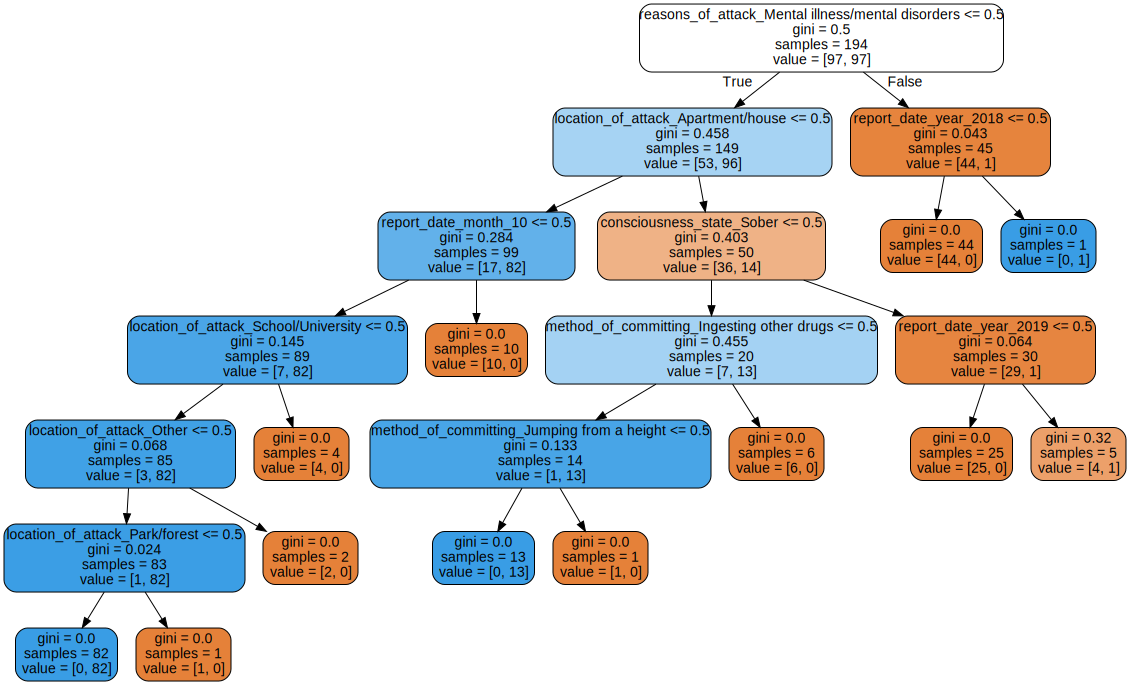

In [1145]:
# Eksportowanie drzewa do pliku DOT
export_graphviz(dtc, out_file='tree.dot', feature_names=X_train.columns, filled=True, rounded=True)

# Konwersja pliku DOT na obraz
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)